# TRADING ALGORÍTMICO: UN ESTUDIO COMPARATIVO ENTRE TÉCNICAS DE CLASIFICACIÓN Y REGRESIÓN EN EL ÁMBITO DE LAS FINANZAS

### Introducción al Proyecto Final - ITBA ECD 2019

El presente trabajo busca desarrollar un algoritmo de backtesting de estrategias de trading de acciones en la bolsa de Estados Unidos utilizando técnicas de Machine Learning.
Los modelos de Machine Learning utilizarán features construidos través de los indicadores típicos del análisis técnico de acciones, además de las variables inherentes del dataset.
Se busca no solamente generar una herramienta de trading algorítmico sino también evaluar diferentes técnicas y enfoques para resolver el problema.

## Etapa de ETL

In [ ]:
# Importo librerías
import sys
!{sys.executable} -m pip install yfinance lxml matplotlib pandas datetime numpy seaborn sklearn tqdm keras tensorflow hyperopt scikit-optimize

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 245kB 11.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=978c87d23eca6ac9f111a6d80bdd2b4b2234bba945f4153ef889a59dad4a6a9d
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
ERROR: yfinance 0.1.55 has requirement lxml>=4.5.1, but you'll have lxml 4.2.6 which is incompatible.


In [ ]:
# Descargo TA-Lib para el cálculo de indicadores de análisis técnico
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

--2020-11-15 13:23:20--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-11-15 13:23:20--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-11-15 13:23:20--  https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixnap

In [ ]:
# Levanto la información de las acciones deseadas para analizar
import yfinance as yf
import pandas as pd

stocks = ['AAL','MSFT', 'AAPL', 'AMZN','BA','GOOG', 'NVDA','CTSH','TSLA','M']

for i in stocks:
    ticker = yf.Ticker(i)
    # Obtener informacion historica de precios
    df_aux = pd.DataFrame(ticker.history(start="2012-01-01", end="2019-12-31"))
    df_aux['ticker'] = str(i)
    df_aux['date'] = df_aux.index
    print("imprimiendo "+str(i))
    if stocks.index(i)==0:
        df = df_aux
    else:
        df = df.append(df_aux, ignore_index = True)    

        
df = df.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Dividends": "dividends", "Stock Splits": "splits"})
df = df.set_index(['ticker','date'])
#df = df.drop('Adj Close')
df.info()
df.to_csv(path_or_buf='stocks_raw.csv')

imprimiendo AAL
imprimiendo MSFT
imprimiendo AAPL
imprimiendo AMZN
imprimiendo BA
imprimiendo GOOG
imprimiendo NVDA
imprimiendo CTSH
imprimiendo TSLA
imprimiendo M
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20110 entries, ('AAL', Timestamp('2012-01-03 00:00:00')) to ('M', Timestamp('2019-12-30 00:00:00'))
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       20110 non-null  float64
 1   high       20110 non-null  float64
 2   low        20110 non-null  float64
 3   close      20110 non-null  float64
 4   volume     20110 non-null  int64  
 5   dividends  20110 non-null  float64
 6   splits     20110 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.2+ MB


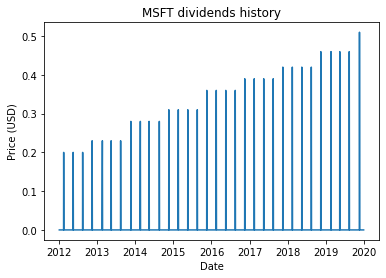

In [ ]:
from matplotlib import pyplot as plt
def graf(df,ticker,start,end,feature):
  stock = df.loc[ticker]
  plt.plot(df.loc[ticker][feature])
  plt.title(ticker + ' ' + feature + ' history')
  if feature=='volume':
    plt.ylabel('Volume')
  else:
    plt.ylabel('Price (USD)')
  plt.xlabel('Date')
  plt.show()

graf(df,'MSFT','2019-01-01','2019-12-31','dividends')

In [ ]:
# Chequeo nulos
print("check de nulos\n", df.isna().sum())
print(df[df['open'].isna()])

check de nulos
 open         0
high         0
low          0
close        0
volume       0
dividends    0
splits       0
dtype: int64
Empty DataFrame
Columns: [open, high, low, close, volume, dividends, splits]
Index: []


## Feature Engineering

In [ ]:
# Feature Engineering básico

df['amplitude'] = df['high']-df['low']
df['amplitude_%'] = (df['high']-df['low'])/df['open']
df['daily_change'] = df['close']-df['open']
df['daily_change_%'] = (df['close']-df['open'])/df['open']
df['dividend_flag'] = 0
df['dividend_flag'][df['dividends'] > 0] = 1
df['dividend_flag_lead'] = df.groupby('ticker')['dividend_flag'].shift(-1)
df['aux_dividend_count'] = df.groupby('ticker')['dividend_flag'].cumsum()
df['days_to_dividend'] = df.groupby(['ticker','aux_dividend_count']).cumcount(ascending=False)+1
df = df.drop(['aux_dividend_count'],axis=1)
df['flag_10_days_to_dividend'] = 0
df['flag_10_days_to_dividend'][df['days_to_dividend'] <= 10] = 1
df['close_lead'] = df.groupby('ticker')['close'].shift(-1)
df['open_lead'] = df.groupby('ticker')['open'].shift(-1)
df['close_lag'] = df.groupby('ticker')['close'].shift(1)
df['close_change_percent'] = df.groupby('ticker')['close'].pct_change(1)
df['close_change_percent_lead'] = df.groupby('ticker')['close_change_percent'].shift(-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
stocks_aggregate = df.groupby('ticker').agg({'volume':'mean','amplitude_%':'mean','daily_change_%':'mean','close_change_percent':'mean','dividend_flag':'sum'})
print(stocks_aggregate)

              volume  amplitude_%  ...  close_change_percent  dividend_flag
ticker                             ...                                     
AAL     8.590609e+06     0.032831  ...              0.001189             22
AAPL    2.379867e+08     0.018073  ...              0.000997             30
AMZN    4.025639e+06     0.020818  ...              0.001335              0
BA      4.417755e+06     0.017622  ...              0.000946             33
CTSH    4.351479e+06     0.018666  ...              0.000463             12
GOOG    2.554052e+06     0.016723  ...              0.000800              0
M       7.260784e+06     0.025913  ...              0.000058             32
MSFT    3.443634e+07     0.016730  ...              0.001080             32
NVDA    1.113597e+07     0.027120  ...              0.001714             29
TSLA    3.100082e+07     0.036848  ...              0.001830              0

[10 rows x 5 columns]


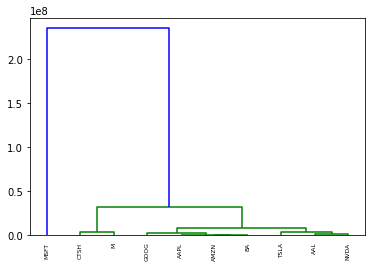

In [ ]:
# Clustering jerárquico para entender qué tickers se parecen entre sí

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# Calculate the linkage: mergings
mergings = linkage(stocks_aggregate,method='complete')

# Plot the dendrogram, using varieties as labels
dendrogram(mergings,
           labels=stocks,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

In [ ]:
# Armo funciones para calcular los indicadores de Análisis Técnico agrupado en cada ticker

import talib

#SMA

def calculate_SMA(df,feature,periods):
  SMA_tickers = []
  for ticker,new_df in df.groupby('ticker'):
    SMA_tickers.append(talib.SMA(new_df[feature],periods))
  SMA = pd.concat(SMA_tickers)
  df = pd.concat([df,SMA.rename('SMA_'+feature+'_'+str(periods))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#EMA

def calculate_EMA(df,feature,periods):
  EMA_tickers = []
  for ticker,new_df in df.groupby('ticker'):
    EMA_tickers.append(talib.EMA(new_df[feature],periods))
  EMA = pd.concat(EMA_tickers)
  df = pd.concat([df,EMA.rename('EMA_'+feature+'_'+str(periods))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#BB

def calculate_BB(df,feature,periods,n_dev):
  UBB_tickers = []
  MBB_tickers = []
  LBB_tickers = []

  for ticker,new_df in df.groupby('ticker'):
    upperband, middleband, lowerband = talib.BBANDS(new_df[feature], timeperiod=periods, nbdevup=n_dev, nbdevdn=n_dev, matype=0)
    UBB_tickers.append(upperband)
    MBB_tickers.append(middleband)
    LBB_tickers.append(lowerband)

  UBB = pd.concat(UBB_tickers)
  MBB = pd.concat(MBB_tickers)
  LBB = pd.concat(LBB_tickers)
  df = pd.concat([df,UBB.rename('UBB_'+feature+'_'+str(periods)),MBB.rename('MBB_'+feature+'_'+str(periods)),LBB.rename('LBB_'+feature+'_'+str(periods))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#MACD

def calculate_MACD(df,feature,fastperiod=12, slowperiod=26, signalperiod=9):
  MACD_tickers = []
  MACD_S_tickers = []
  MACD_H_tickers = []

  for ticker,new_df in df.groupby('ticker'):
    macd, macdsignal, macdhist = talib.MACD(new_df[feature], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
    MACD_tickers.append(upperband)
    MACD_S_tickers.append(middleband)
    MACD_H_tickers.append(lowerband)

  MACD = pd.concat(MACD_tickers)
  MACD_S = pd.concat(MACD_S_tickers)
  MACD_H = pd.concat(MACD_H_tickers)
  df = pd.concat([df,MACD.rename('MACD_'+feature+'_'+str(fastperiod)+'_'+str(slowperiod)+'_'+str(signalperiod)),MACD_S.rename('MACD_signal_'+feature+'_'+str(fastperiod)+'_'+str(slowperiod)+'_'+str(signalperiod)),MACD_H.rename('MACD_hist_'+feature+'_'+str(fastperiod)+'_'+str(slowperiod)+'_'+str(signalperiod))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#RSI

def calculate_RSI(df,feature,periods):
  RSI_tickers = []
  for ticker,new_df in df.groupby('ticker'):
    RSI_tickers.append(talib.RSI(new_df[feature],periods))
  RSI = pd.concat(RSI_tickers)
  df = pd.concat([df,RSI.rename('RSI_'+feature+'_'+str(periods))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#STOCHASTIC

def calculate_STOCH(df,fastk_period=5, slowk_period=3, slowd_period=3):
  STOCH_K_tickers = []
  STOCH_D_tickers = []
  
  for ticker,new_df in df.groupby('ticker'):
    slowk, slowd = talib.STOCH(df['high'], df['low'], df['close'],fastk_period=fastk_period, slowk_period=slowk_period, slowk_matype=0, slowd_period=slowd_period, slowd_matype=0)
    STOCH_K_tickers.append(slowk)
    STOCH_D_tickers.append(slowd)

  STOCH_K = pd.concat(STOCH_K_tickers)
  STOCH_D = pd.concat(STOCH_D_tickers)
  df = pd.concat([df,STOCH_K.rename('STOCH_k'),STOCH_D.rename('STOCH_d')],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df

#WILLIAMS R

def calculate_WR(df,periods):
  WR_tickers = []
  for ticker,new_df in df.groupby('ticker'):
    WR_tickers.append(talib.WILLR(new_df['high'], new_df['low'], new_df['close'],periods))
  WR = pd.concat(WR_tickers)
  df = pd.concat([df,WR.rename('Williams_R_'+str(periods))],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df


#ON BALANCE VOLUME

def calculate_OBV(df):
  OBV_tickers = []
  for ticker,new_df in df.groupby('ticker'):
    OBV_tickers.append(talib.OBV(new_df['close'], new_df['volume']))
  OBV = pd.concat(OBV_tickers)
  df = pd.concat([df,OBV.rename('OBV')],axis=1,join='inner')
  df.sort_index(inplace=True)
  return df


In [ ]:
# Aplico las funciones generadas para armar nuevas features

# Simple Moving Averages

df = calculate_SMA(df,'close',14)
df = calculate_SMA(df,'close',26)
df = calculate_SMA(df,'close',50)
df = calculate_SMA(df,'close',200)

df = calculate_SMA(df,'close_change_percent',14)
df = calculate_SMA(df,'close_change_percent',26)
df = calculate_SMA(df,'close_change_percent',50)
df = calculate_SMA(df,'close_change_percent',200)

# Exponential Moving Averages

df = calculate_EMA(df,'close',14)
df = calculate_EMA(df,'close',26)
df = calculate_EMA(df,'close',50)
df = calculate_EMA(df,'close',200)

df = calculate_EMA(df,'close_change_percent',14)
df = calculate_EMA(df,'close_change_percent',26)
df = calculate_EMA(df,'close_change_percent',50)
df = calculate_EMA(df,'close_change_percent',200)

# Boillinger Bands

df = calculate_BB(df,'close',periods=20,n_dev=2)

# MACD

#df = calculate_MACD(df,'close')

# RSI

df = calculate_RSI(df,'close',periods=14)

# Stochastic

#df = calculate_STOCH(df)

# Williams R

df = calculate_WR(df,periods=14)

# On Balance Volume

df = calculate_OBV(df)

# Otros

df['std_close'] = df.groupby('ticker')['close'].apply(lambda x:x.rolling(window=360, min_periods=1).std())
df['std_close_change_percent'] = df.groupby('ticker')['close_change_percent'].apply(lambda x:x.rolling(window=360, min_periods=1).std())
df['high_14'] = df.groupby('ticker')['high'].apply(lambda x:x.rolling(window=14, min_periods=1).max())
df['high_26'] = df.groupby('ticker')['high'].apply(lambda x:x.rolling(window=26, min_periods=1).max())
df['high_50'] = df.groupby('ticker')['high'].apply(lambda x:x.rolling(window=50, min_periods=1).max())
df['high_200'] = df.groupby('ticker')['high'].apply(lambda x:x.rolling(window=200, min_periods=1).max())
df['low_14'] = df.groupby('ticker')['low'].apply(lambda x:x.rolling(window=14, min_periods=1).min())
df['low_26'] = df.groupby('ticker')['low'].apply(lambda x:x.rolling(window=26, min_periods=1).min())
df['low_50'] = df.groupby('ticker')['low'].apply(lambda x:x.rolling(window=50, min_periods=1).min())
df['low_200'] = df.groupby('ticker')['low'].apply(lambda x:x.rolling(window=200, min_periods=1).min())

df.info()
df.to_csv(path_or_buf='stocks_df.csv')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20110 entries, ('AAL', Timestamp('2012-01-03 00:00:00')) to ('TSLA', Timestamp('2019-12-30 00:00:00'))
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open                          20110 non-null  float64
 1   high                          20110 non-null  float64
 2   low                           20110 non-null  float64
 3   close                         20110 non-null  float64
 4   volume                        20110 non-null  int64  
 5   dividends                     20110 non-null  float64
 6   splits                        20110 non-null  float64
 7   amplitude                     20110 non-null  float64
 8   amplitude_%                   20110 non-null  float64
 9   daily_change                  20110 non-null  float64
 10  daily_change_%                20110 non-null  float64
 11  dividend_flag                 20110 non-nu

In [ ]:
df.head(30)

open      high       low  ...    low_26    low_50   low_200
ticker date                                      ...                              
AAL    2012-01-03  4.902256  4.921111  4.779700  ...  4.779700  4.779700  4.779700
       2012-01-04  4.798554  4.883400  4.685425  ...  4.685425  4.685425  4.685425
       2012-01-05  4.855118  5.166223  4.779699  ...  4.685425  4.685425  4.685425
       2012-01-06  5.128513  5.345344  5.090804  ...  4.685425  4.685425  4.685425
       2012-01-09  5.241642  5.467901  5.232215  ...  4.685425  4.685425  4.685425
       2012-01-10  5.477328  5.477328  5.288780  ...  4.685425  4.685425  4.685425
       2012-01-11  5.364200  5.599885  5.345345  ...  4.685425  4.685425  4.685425
       2012-01-12  5.562174  5.750722  5.401908  ...  4.685425  4.685425  4.685425
       2012-01-13  5.618739  5.844997  5.571602  ...  4.685425  4.685425  4.685425
       2012-01-17  5.665877  5.675304  5.515038  ...  4.685425  4.685425  4.685425
       2012-01-18  5.524465  5.863851  5.477328  ...  4.685425  4.685425  4.685425
       2012-01-19  5.713015  5.939273  5.684733  ...  4.685425  4.685425  4.685425
       2012-01-20  5.882707  6.193812  5.844997  ...  4.685425  4.685425  4.685425
       2012-01-23  6.061829  6.118393  5.844998  ...  4.685425  4.685425  4.685425
       2012-01-24  5.854424  6.156101  5.760150  ...  4.685425  4.685425  4.685425
       2012-01-25  6.599191  7.485368  6.495489  ...  4.685425  4.685425  4.685425
       2012-01-26  7.334528  7.796472  7.211972  ...  4.685425  4.685425  4.685425
       2012-01-27  7.353383  7.796472  7.315674  ...  4.685425  4.685425  4.685425
       2012-01-30  8.032156  8.286696  7.834180  ...  4.685425  4.685425  4.685425
       2012-01-31  7.975592  8.013301  7.636205  ...  4.685425  4.685425  4.685425
       2012-02-01  7.985021  8.437536  7.871892  ...  4.685425  4.685425  4.685425
       2012-02-02  8.456391  8.720359  8.333835  ...  4.685425  4.685425  4.685425
       2012-02-03  8.814634  9.342569  8.786351  ...  4.685425  4.685425  4.685425
       2012-02-06  9.059745  9.069173  8.531811  ...  4.685425  4.685425  4.685425
       2012-02-07  8.635511  8.833486  8.428107  ...  4.685425  4.685425  4.685425
       2012-02-08  8.710931  8.729787  8.277270  ...  4.685425  4.685425  4.685425
       2012-02-09  8.626086  8.626086  8.107579  ...  4.685425  4.685425  4.685425
       2012-02-10  8.333836  8.560094  8.248989  ...  4.779699  4.685425  4.685425
       2012-02-13  8.465817  8.701503  8.465817  ...  5.090804  4.685425  4.685425
       2012-02-14  8.560092  8.720358  8.380971  ...  5.232215  4.685425  4.685425

[30 rows x 52 columns]

In [ ]:
df.groupby('ticker').describe()

open                          ...     low_200                         
         count        mean         std  ...         50%         75%          max
ticker                                  ...                                     
AAL     2011.0   32.778904   12.841918  ...   26.062956   32.517389    41.439788
AAPL    2011.0   29.574001   12.957495  ...   20.791915   32.695829    41.577036
AMZN    2011.0  803.272064  583.348991  ...  365.649994  833.500000  1672.000000
BA      2011.0  174.622286  107.541408  ...  100.370629  162.476813   315.816946
CTSH    2011.0   54.022403   14.069990  ...   43.535938   55.090584    68.197389
GOOG    2011.0  735.905954  299.305328  ...  515.179993  803.369995  1025.000000
M       2011.0   30.629785    9.716979  ...   22.960509   28.686560    41.981988
MSFT    2011.0   59.746216   34.973125  ...   35.988131   60.639912   113.420726
NVDA    2011.0   83.981530   84.296263  ...   18.535406   94.477051   202.366908
TSLA    2011.0   42.582424   19.961765  ...   35.397999   36.279999    58.526001

[10 rows x 416 columns]

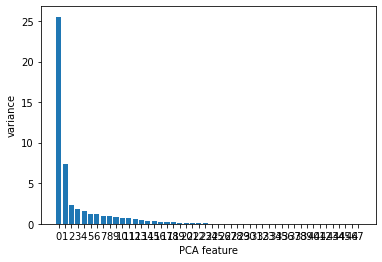

In [ ]:
# PCA para descubrir las variables relevantes

# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import numpy as np

#Impute NaNs
df_aux = df.drop(['dividend_flag_lead','close_lead','close_change_percent_lead','open_lead'],axis=1)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df_aux)
df_non_null = imp_mean.transform(df_aux)

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(df_non_null)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
pca_definitive = PCA(n_components=3)
pipeline_definitive = make_pipeline(scaler,pca_definitive)
pipeline_definitive.fit(df_non_null)
pca_features = pd.DataFrame(pipeline_definitive.transform(df_non_null),index=df.index)
print(pca_features)

                          0         1         2
ticker date                                    
AAL    2012-01-03 -1.375152 -0.119123  0.581895
       2012-01-04 -1.602380 -0.265153  1.029809
       2012-01-05 -1.958039  1.369155 -0.233349
       2012-01-06 -1.792065  0.565734  0.567186
       2012-01-09 -1.734776  0.495760  0.196056
...                     ...       ...       ...
TSLA   2019-12-23 -1.997422  8.289728  0.502744
       2019-12-24 -1.972584  8.308100  0.976875
       2019-12-26 -1.958579  8.426474  1.109341
       2019-12-27 -1.948754  7.604121  2.030739
       2019-12-30 -1.972541  5.165959  4.015567

[20110 rows x 3 columns]


In [ ]:
print(pca_features.join(df['close_change_percent_lead']))

                          0         1         2  close_change_percent_lead
ticker date                                                               
AAL    2012-01-03 -1.375152 -0.119123  0.581895                  -0.017578
       2012-01-04 -1.602380 -0.265153  1.029809                   0.087475
       2012-01-05 -1.958039  1.369155 -0.233349                   0.023766
       2012-01-06 -1.792065  0.565734  0.567186                   0.021429
       2012-01-09 -1.734776  0.495760  0.196056                   0.000000
...                     ...       ...       ...                        ...
TSLA   2019-12-23 -1.997422  8.289728  0.502744                   0.014384
       2019-12-24 -1.972584  8.308100  0.976875                   0.013380
       2019-12-26 -1.958579  8.426474  1.109341                  -0.001300
       2019-12-27 -1.948754  7.604121  2.030739                  -0.036433
       2019-12-30 -1.972541  5.165959  4.015567                        NaN

[20110 rows x 4 columns]

## Estimación de precio con modelos de regresión

A continuación se prueban diferentes modelos de regresión para encontrar el que mejor performance tenga para cada ticker. 

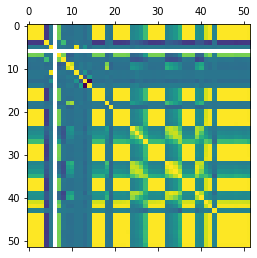

In [ ]:
# Elijo un ticker como ejemplo
ticker = 'MSFT'
dataset = df.loc[ticker]
dataset = dataset.loc[:, dataset.columns != 'ticker']
dataset = dataset.loc[:, dataset.columns != 'date']
dataset.describe()
import matplotlib.pyplot as plt
plt.matshow(dataset.corr())
plt.show()

In [ ]:
# Genero una función de evaluación custom

from sklearn.metrics import make_scorer, balanced_accuracy_score

def Forecast_Accuracy(est, X, y):  
  y_predict = est.predict(X)
  FA = 1-np.sum(np.square(y-y_predict))/np.sum(y)
  return FA

def performance_price_reg(y,y_pred):  
  close = np.roll(y,1)
  close[0] = y[0]
  errors = np.where(y_pred > close,np.where(y_pred>y,0,y-y_pred),np.where(y_pred<y,0,y_pred-y))
  performance = 1-np.sum(np.square(errors))/np.sum(y)
  return performance

def performance_change_reg(y,y_pred):  
  errors = np.where(y_pred > 0,np.where(y_pred>y,0,y-y_pred),np.where(y_pred<y,0,y_pred-y))
  performance = 1-np.sum(np.square(errors))
  return performance


price_reg_scorer = make_scorer(performance_price_reg)
change_reg_scorer = make_scorer(performance_change_reg)
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

In [ ]:
from skopt.space import Real, Categorical, Integer

lr_space = {'fit_intercept': Categorical([True,False]), 'normalize': Categorical([True,False])}
rf_space = {'n_estimators': Integer(50,300), 'max_depth': Integer(1,20),'min_samples_split': Integer(2,20), 'max_features': Real(0.1,0.8)}
xgb_space = {'learning_rate': Real(0.05, 0.30),'max_depth' : Integer(3,20),'min_child_weight': Integer(1,7), 'gamma': Real(0.0,0.4),'colsample_bytree': Real(0.3,0.7)}


In [ ]:
# Busco el mejor modelo de regresión para un ticker cualquiera
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from skopt import BayesSearchCV
import pickle

#regressors = {'Linear Regression': [LinearRegression(),lr_space], 'Support Vector Regressor': [SVR(),svr_space], 'XGBoost': [xgb.XGBRegressor(),xgb_space]}
regressors = {'Linear Regression': [LinearRegression(),lr_space], 'Random Forest': [RandomForestRegressor(random_state=1111),rf_space],'XGBoost': [xgb.XGBRegressor(random_state=1111),xgb_space]}

def best_model_reg (regressors,label,train_size,test_size,ticker,df):
    best_FA = -9999
    best_model = 'None'
    print('Ticker:',ticker)
    eliminate_features = ['open_lead','close_lead','close_change_percent_lead']
    eliminate_features.remove(label)
    dataset = df.drop(eliminate_features,axis=1)
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=5,max_train_size=300)
    if label=='close_change_percent_lead':
      scoring_function = change_reg_scorer
    else:
      scoring_function = price_reg_scorer
    for regressor in regressors.values():
      reg = regressor[0]
      search_space = regressor[1]
      opt_model = BayesSearchCV(estimator=reg, search_spaces=search_space,n_iter=15,scoring=scoring_function,random_state=1111,n_jobs=4,return_train_score=True,refit=True)
      opt_model.fit(X_train,y_train)
      y_pred = opt_model.predict(X_test)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      if label=='close_change_percent_lead':
        FA = performance_change_reg(y_test, y_pred)
      else:
        FA= performance_price_reg(y_test, y_pred)
      print(estimator)
      print(' Forecast Accuracy: ', FA)
      print(' Forecast Accuracy (CV): ', cv_scores_mean)
      if (FA>=best_FA):
          best_FA = FA
          best_regressor = estimator
          cv_scores_mean = cv_scores_mean
    
    print('Best model is: ',best_regressor,' with test FA=',best_FA,' and CV FA=',cv_scores_mean)
    best_regressor.fit(X_train,y_train)
    y_pred = best_regressor.predict(X_test)
    plt.figure()
    plt.plot(dates_test,y_test)
    plt.plot(dates_test,y_pred)
    plt.title(ticker + ' '+ label + ' prediction in test set')
    plt.ylabel(label)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.legend(['Actual','Predicted'], loc='upper left')
    plt.show()

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    best_regressor.fit(X_train,y_train)

    filename = ticker + '_' + label + '_allfeatures.sav'
    pickle.dump(best_regressor, open(filename, 'wb'))
    return ticker, label, filename, best_FA, cv_scores_mean


In [ ]:
def best_model_reg_features (regressors,label,train_size,test_size,ticker,df):
    best_FA = -9999
    best_model = 'None'
    print('Ticker:',ticker)
    eliminate_features = ['open_lead','close_lead','close_change_percent_lead']
    eliminate_features.remove(label)
    dataset = df.drop(eliminate_features,axis=1)
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=5,max_train_size=300)
    if label=='close_change_percent_lead':
      scoring_function = change_reg_scorer
    else:
      scoring_function = price_reg_scorer
    lasso=Lasso()
    lasso.fit(X_train,y_train)
    lasso_coef = lasso.coef_
    #columns = list(X_train.columns.values)
    columns = X_train.columns
    # Ploteo los coeficientes
    plt.plot(range(len(columns)), lasso_coef)
    plt.xticks(range(len(columns)), columns, rotation=60)
    plt.margins(0.02)
    plt.show()

    reg_coef = pd.DataFrame({'feature':columns,'lasso_coef':lasso_coef})
    indexes = reg_coef['feature'][(reg_coef['lasso_coef']>0)|(reg_coef['lasso_coef']<0)].index
    #indexes = list(indexes)
    print(indexes)
    X_train_sub = X_train[X_train.columns[indexes]]
    X_test_sub = X_test[X_test.columns[indexes]]
    print('Columns selected: '+X_train_sub.columns)

    for regressor in regressors.values():
      reg = regressor[0]
      search_space = regressor[1]
      opt_model = BayesSearchCV(estimator=reg, search_spaces=search_space,n_iter=15,scoring=scoring_function,random_state=1111,n_jobs=4,return_train_score=True,refit=True)
      opt_model.fit(X_train_sub,y_train)
      y_pred = opt_model.predict(X_test_sub)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      if label=='close_change_percent_lead':
        FA = performance_change_reg(y_test, y_pred)
      else:
        FA= performance_price_reg(y_test, y_pred)
      print(estimator)
      print(' Forecast Accuracy: ', FA)
      print(' Forecast Accuracy (CV): ', cv_scores_mean)
      if (FA>=best_FA):
          best_FA = FA
          best_regressor = estimator
          cv_scores_mean = cv_scores_mean
    
    print('Best model is: ',best_regressor,' with test FA=',best_FA,' and CV FA=',cv_scores_mean)
    best_regressor.fit(X_train_sub,y_train)
    y_pred = best_regressor.predict(X_test_sub)
    plt.figure()
    plt.plot(dates_test,y_test)
    plt.plot(dates_test,y_pred)
    plt.title(ticker + ' '+ label + ' prediction in test set')
    plt.ylabel(label)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.legend(['Actual','Predicted'], loc='upper left')
    plt.show()

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    best_regressor.fit(X_train,y_train)

    filename = ticker + '_' + label + '_subsetfeatures.sav'
    pickle.dump(best_regressor, open(filename, 'wb'))
    return ticker, label, filename, best_FA, cv_scores_mean

In [ ]:
def best_pca_model_reg (regressors,label,train_size,test_size,ticker,df):
    best_FA = -9999
    best_model = 'None'
    print('Ticker:',ticker)
    dataset = pca_features.join(df[label])
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=5,max_train_size=300)
    if label=='close_change_percent_lead':
      scoring_function = change_reg_scorer
    else:
      scoring_function = price_reg_scorer

    for regressor in regressors.values():
      reg = regressor[0]
      search_space = regressor[1]
      opt_model = BayesSearchCV(estimator=reg, search_spaces=search_space,n_iter=15,scoring=scoring_function,random_state=1111,n_jobs=4,return_train_score=True,refit=True)
      opt_model.fit(X_train,y_train)
      y_pred = opt_model.predict(X_test)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      if label=='close_change_percent_lead':
        FA = performance_change_reg(y_test, y_pred)
      else:
        FA= performance_price_reg(y_test, y_pred)
      print(estimator)
      print(' Forecast Accuracy: ', FA)
      print(' Forecast Accuracy (CV): ', cv_scores_mean)
      if (FA>=best_FA):
          best_FA = FA
          best_regressor = estimator
          cv_scores_mean = cv_scores_mean
    
    print('Best model is: ',best_regressor,' with test FA=',best_FA,' and CV FA=',cv_scores_mean)
    best_regressor.fit(X_train,y_train)
    y_pred = best_regressor.predict(X_test)
    plt.figure()
    plt.plot(dates_test,y_test)
    plt.plot(dates_test,y_pred)
    plt.title(ticker + ' '+ label + ' prediction in test set')
    plt.ylabel(label)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.legend(['Actual','Predicted'], loc='upper left')
    plt.show()

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    lasso.fit(X_train,y_train)
    lasso_coef = lasso.coef_[0]
    columns = X_train.columns.values
    indexes = reg_coef['feature'][(reg_coef['lasso_coef']>0)|(reg_coef['lasso_coef']<0)].index
    indexes = indexes
    X_train_sub = X_train[X_train.columns[indexes]]
    best_regressor.fit(X_train_sub,y_train)

    filename = ticker + '_' + label + '_lassofeatures.sav'
    pickle.dump(best_regressor, open(filename, 'wb'))
    return ticker, label, filename, best_FA, cv_scores_mean

In [ ]:
column_names = ["ticker", "preprocessing", "label","features","best_model", "best_FA", "cv_score_in_best"]
models_df = pd.DataFrame(columns = column_names)

Ticker: AAL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.995146470612733
 Forecast Accuracy (CV):  0.9940086259928571
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.4412399307415884,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=238,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9991556005936485
 Forecast Accuracy (CV):  0.9966657680478137
[20:03:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

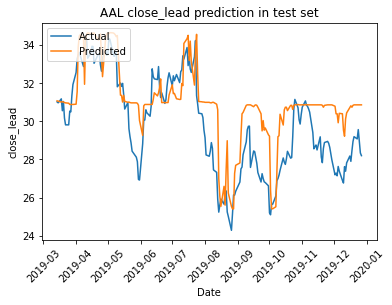

Ticker: AAL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9638626560969478
 Forecast Accuracy (CV):  0.9312282341162909
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9693058843037633
 Forecast Accuracy (CV):  0.9182939603196509
[20:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,

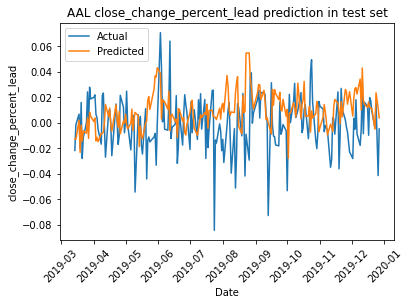

Ticker: AAL


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192.2302334658807, tolerance: 32.59106170553315
  positive)


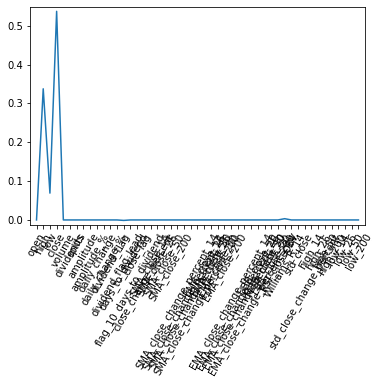

Int64Index([1, 2, 3, 4, 13, 37, 38], dtype='int64')
Index(['Columns selected: high', 'Columns selected: low',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: days_to_dividend', 'Columns selected: Williams_R_14',
       'Columns selected: OBV'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9941004384717599
 Forecast Accuracy (CV):  0.9937111828511357
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9999893527435159
 Forecast Accuracy (CV):  0.9995241730658573
[20:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

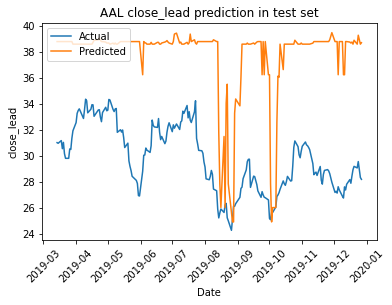

Ticker: AAL


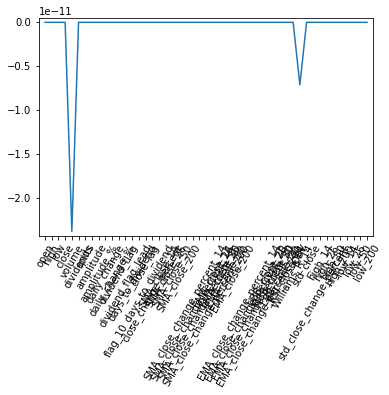

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9609903777373834
 Forecast Accuracy (CV):  0.8917055038937394
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.4554839289144088,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9714675103394068
 Forecast Accuracy (CV):  0.9148645100822592


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:09:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9762314744902462
 Forecast Accuracy (CV):  0.9130271881760414
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

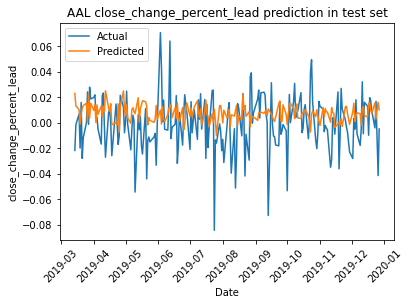

Ticker: AAL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9999918442873299
 Forecast Accuracy (CV):  0.9998590282444906
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9999721940973415
 Forecast Accuracy (CV):  0.9996814706309415
[20:10:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.510636051358

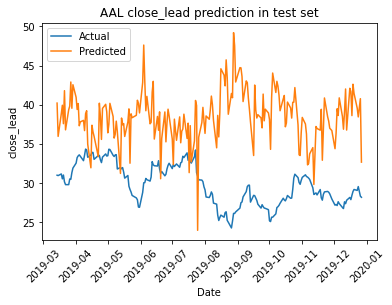

Ticker: AAL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9652708014920006
 Forecast Accuracy (CV):  0.8981829695423711
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.24076556126090504,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=57,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9693894764829698
 Forecast Accuracy (CV):  0.9106918328854015
[20:11:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byn

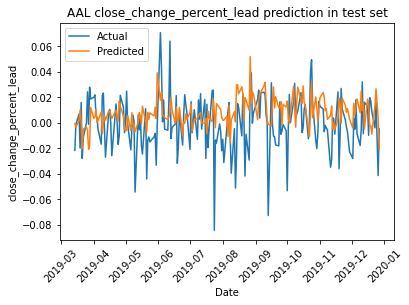

Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9930741947655819
 Forecast Accuracy (CV):  0.9957974538141858
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.4412399307415884,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=238,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.999516559552097
[20:14:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample

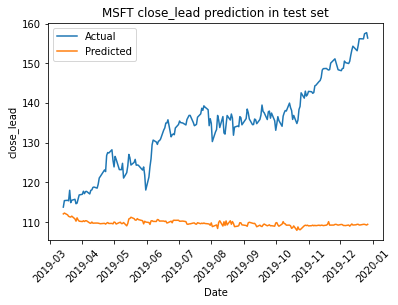

Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9917501561392517
 Forecast Accuracy (CV):  0.9708720866301197
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features=0.7977270616632045,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9996323289649894
 Forecast Accuracy (CV):  0.9773707267883416


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:18:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9910351172938693
 Forecast Accuracy (CV):  0.9742324493008846
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features=0.7977270616632045,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
          

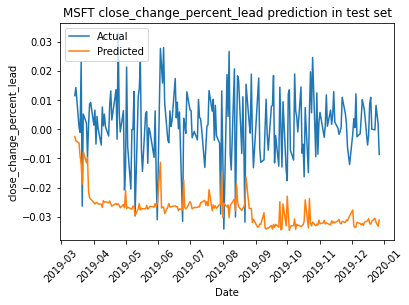

Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2560.8431545083367, tolerance: 119.37639489846174
  positive)


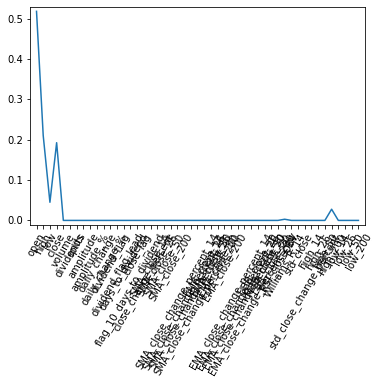

Int64Index([0, 1, 2, 3, 4, 37, 38, 44], dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: low', 'Columns selected: close',
       'Columns selected: volume', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: high_200'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9936104193173367
 Forecast Accuracy (CV):  0.9950775323381494
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999303549339035
[20:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample

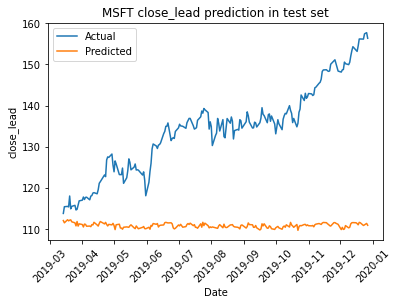

Ticker: MSFT


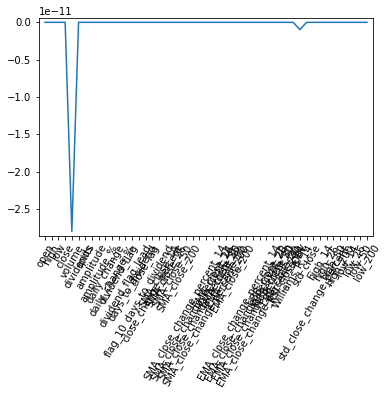

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.987922289071178
 Forecast Accuracy (CV):  0.9629095534601164
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.7253090251783649,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=282,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9940087941236609
 Forecast Accuracy (CV):  0.9734467951367437


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9893818718184142
 Forecast Accuracy (CV):  0.9735117489247284
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.7253090251783649,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
          

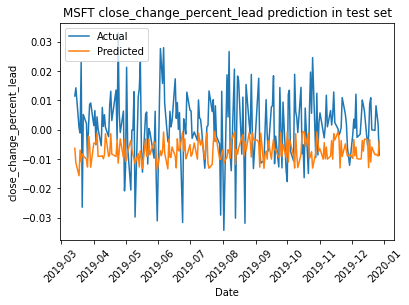

Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999930194883087
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999633656604034
[20:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.40398

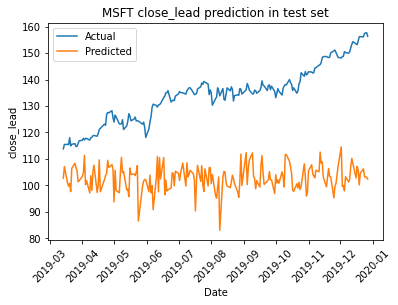

Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9863900530132158
 Forecast Accuracy (CV):  0.9676453842845251
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=54,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9920552606597155
 Forecast Accuracy (CV):  0.9760199915628575


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.987545259423723
 Forecast Accuracy (CV):  0.9774038222629687
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
          

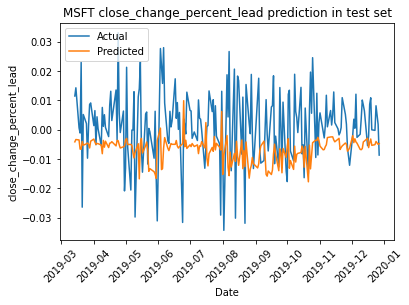

Ticker: AAPL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9969265525974557
 Forecast Accuracy (CV):  0.9976101730246016
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=19, max_features=0.10797902006106865,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=66,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9988805750011203
 Forecast Accuracy (CV):  0.9995378619532695
[20:25:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

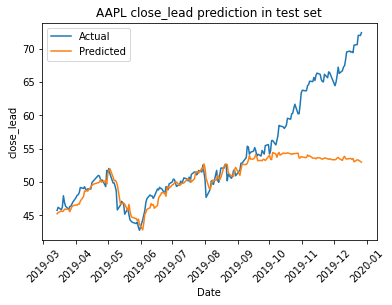

Ticker: AAPL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9889607397304474
 Forecast Accuracy (CV):  0.9697886466977996
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9838492770966627
 Forecast Accuracy (CV):  0.9667595169185611


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9879602318542953
 Forecast Accuracy (CV):  0.9663551147627608
Best model is:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)  with test FA= 0.9889607397304474  and CV FA= 0.9663551147627608


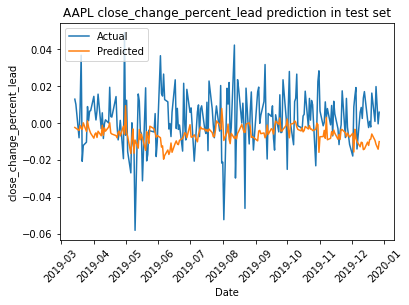

Ticker: AAPL


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2001.1636116745256, tolerance: 20.405080016835182
  positive)


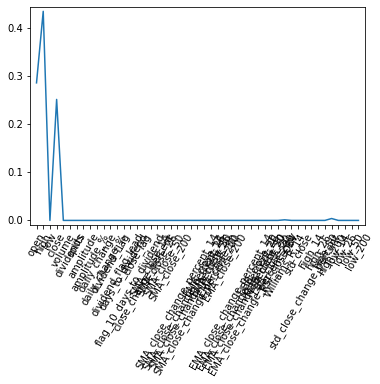

Int64Index([0, 1, 3, 4, 37, 38, 44], dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: high_200'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9937074666888815
 Forecast Accuracy (CV):  0.9971721931749388
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999278392843519
[20:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample

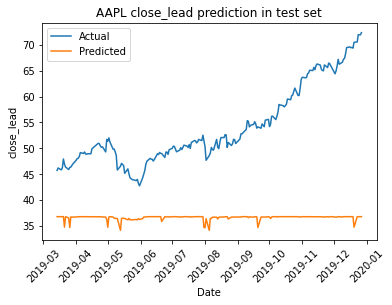

Ticker: AAPL


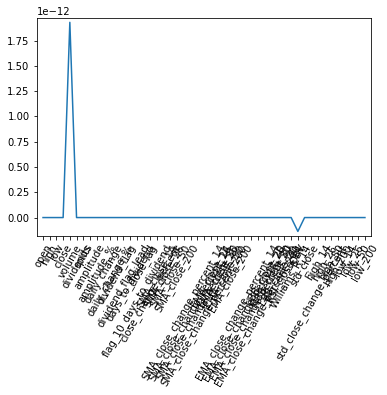

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9745520444320678
 Forecast Accuracy (CV):  0.9535278969746874
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.988274484872855
 Forecast Accuracy (CV):  0.9653916202117471


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9843476026158182
 Forecast Accuracy (CV):  0.9671066837015126
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
     

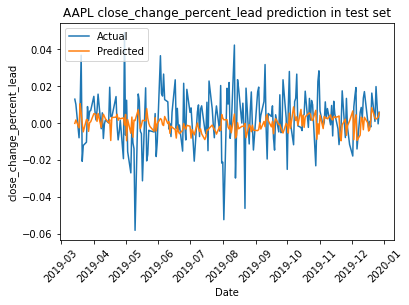

Ticker: AAPL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999422379007648
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features=0.6511704356838013,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=14,
                      min_weight_fraction_leaf=0.0, n_estimators=262,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999884036281719
[20:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6646

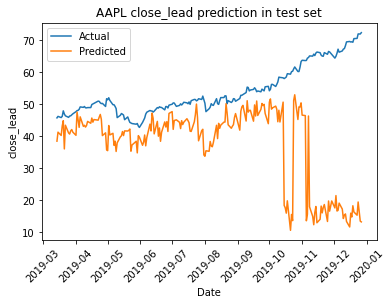

Ticker: AAPL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9760515652351465
 Forecast Accuracy (CV):  0.9565237435453979
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.7543784591557975,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=76,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9763951029761445
 Forecast Accuracy (CV):  0.9668406299407631


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.983395520393224
 Forecast Accuracy (CV):  0.9683415744039816
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=10

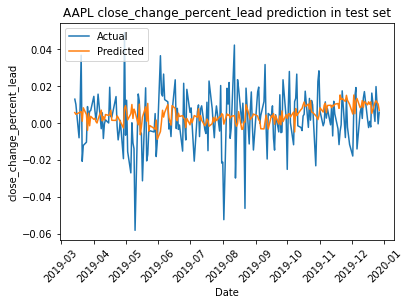

Ticker: AMZN


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9424441456429511
 Forecast Accuracy (CV):  0.9201514597562241
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=0.776613314128121,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=57,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9982572117457844
[20:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_by

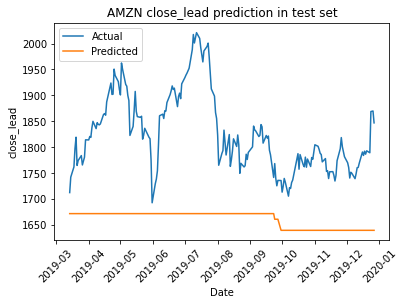

Ticker: AMZN


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9933558951919528
 Forecast Accuracy (CV):  0.9648927178917157
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9976861199164387
 Forecast Accuracy (CV):  0.9634783478365083
[20:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0

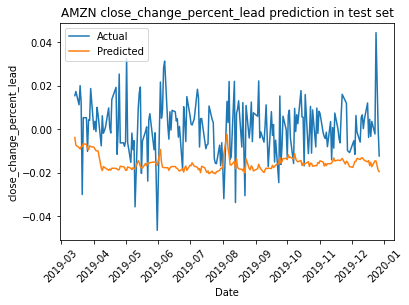

Ticker: AMZN


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256083.4752725058, tolerance: 44754.16682379224
  positive)


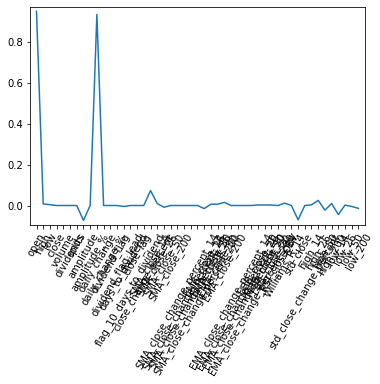

Int64Index([ 0,  1,  2,  4,  7,  9, 13, 17, 18, 19, 25, 26, 27, 28, 33, 34, 35,
            37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: low', 'Columns selected: volume',
       'Columns selected: amplitude', 'Columns selected: daily_change',
       'Columns selected: days_to_dividend', 'Columns selected: SMA_close_14',
       'Columns selected: SMA_close_26', 'Columns selected: SMA_close_50',
       'Columns selected: EMA_close_14', 'Columns selected: EMA_close_26',
       'Columns selected: EMA_close_50', 'Columns selected: EMA_close_200',
       'Columns selected: UBB_close_20', 'Columns selected: MBB_close_20',
       'Columns selected: LBB_close_20', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: std_close',
       'Columns selected: high_14', 'Columns selected: high_26',
       'Columns selected: high_50', 'Columns selected: high_20

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9273291647641393
 Forecast Accuracy (CV):  0.8992547954668896
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.7609462518927563,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=17,
                      min_weight_fraction_leaf=0.0, n_estimators=148,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9606723420856075
 Forecast Accuracy (CV):  0.9969859054555437


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9669394238149948
 Forecast Accuracy (CV):  0.9961234690198146
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100

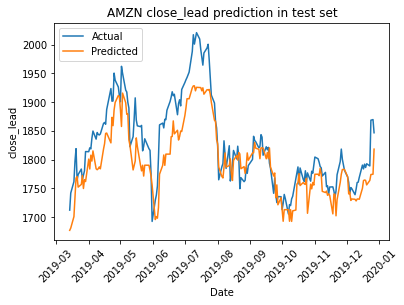

Ticker: AMZN


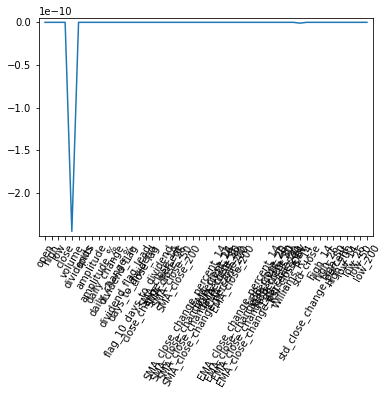

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9873769496347136
 Forecast Accuracy (CV):  0.9436498165522214
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.5061785009144089,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=61,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9897958380752184
 Forecast Accuracy (CV):  0.959884040223484


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9898539815735126
 Forecast Accuracy (CV):  0.9489665502397846
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

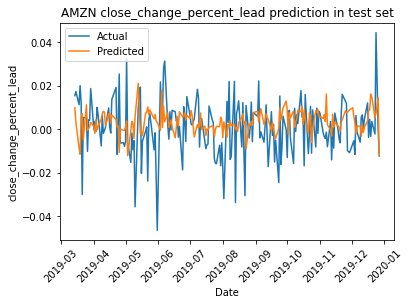

Ticker: AMZN


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.96623866741672
 Forecast Accuracy (CV):  0.9996778132537437
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.4412399307415884,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=238,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.999561144185483
[20:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_b

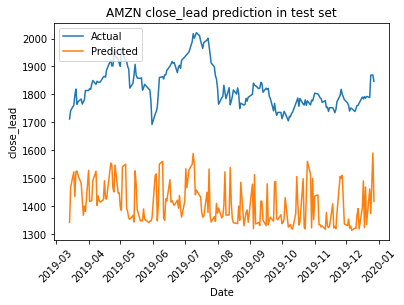

Ticker: AMZN


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9881930144258084
 Forecast Accuracy (CV):  0.93410214385952
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features=0.7831026301636224,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=53,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9905622404595571
 Forecast Accuracy (CV):  0.9510093619017537


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9932047376117786
 Forecast Accuracy (CV):  0.942498057453736
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=10

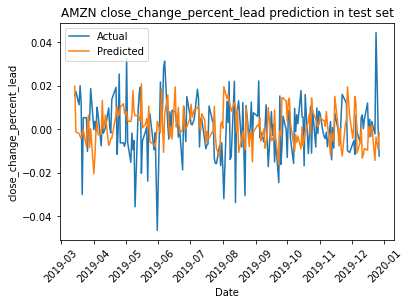

Ticker: BA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.971710724965521
 Forecast Accuracy (CV):  0.9893999318367201
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9996547179085796
[20:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_b

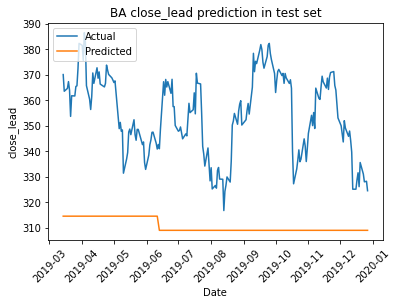

Ticker: BA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9811154515882652
 Forecast Accuracy (CV):  0.9805515366021743
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9835710722200263
 Forecast Accuracy (CV):  0.9759730893195414


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:50:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9764033404448736
 Forecast Accuracy (CV):  0.9809178265838582
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
     

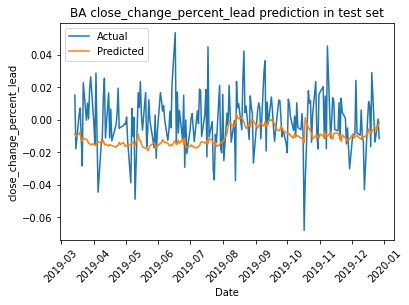

Ticker: BA


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11699.852064745284, tolerance: 1597.9618632091167
  positive)


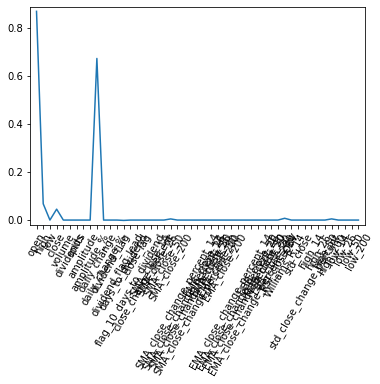

Int64Index([0, 1, 3, 4, 9, 13, 20, 37, 38, 44], dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: daily_change', 'Columns selected: days_to_dividend',
       'Columns selected: SMA_close_200', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: high_200'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9520428438628425
 Forecast Accuracy (CV):  0.9858604863761672
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9997153780200296
[20:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_

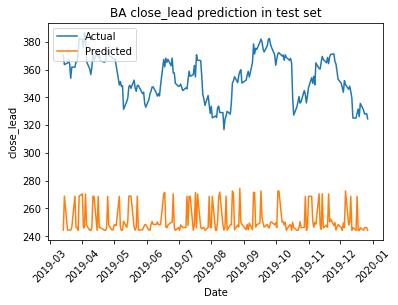

Ticker: BA


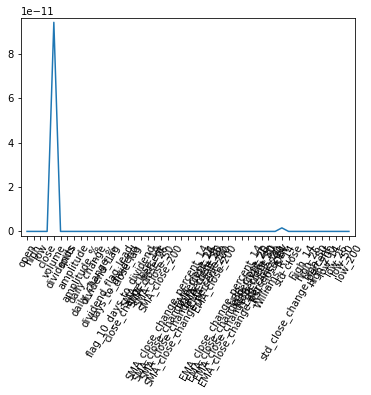

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9753849320515152
 Forecast Accuracy (CV):  0.9645036560280287
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9886675572740279
 Forecast Accuracy (CV):  0.9731726865470134


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:52:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.985093756112029
 Forecast Accuracy (CV):  0.9739882027327387
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
      

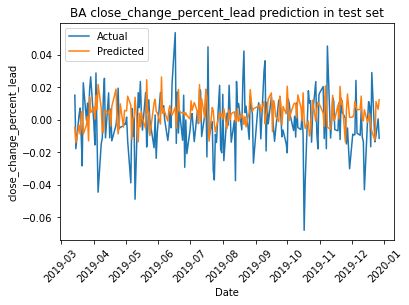

Ticker: BA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  1.0
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.2213370821940342,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=136,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9998961575686868
[20:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.358326710054485,
  

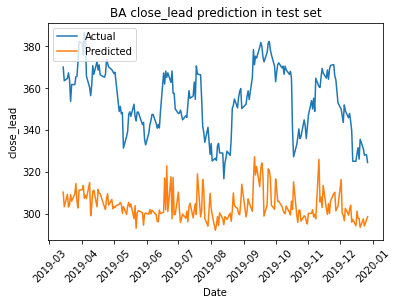

Ticker: BA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9696203966870187
 Forecast Accuracy (CV):  0.9655062437294193
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.24076556126090504,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=57,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9748933132873433
 Forecast Accuracy (CV):  0.9755818530377629


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[20:54:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.978944158485705
 Forecast Accuracy (CV):  0.9773760976142262
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=10

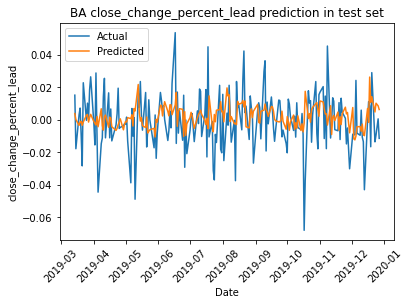

Ticker: GOOG


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.8449862247497577
 Forecast Accuracy (CV):  0.9503340496172842
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.11734307732076035,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=18,
                      min_weight_fraction_leaf=0.0, n_estimators=297,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9998258968514496
[20:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsamp

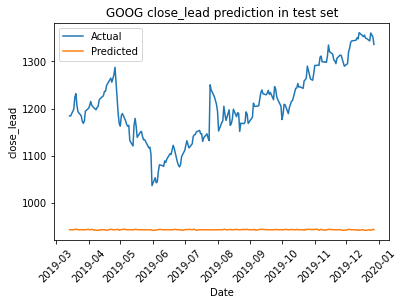

Ticker: GOOG


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9743739358106679
 Forecast Accuracy (CV):  0.9755954488179546
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=54,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9922195759099676
 Forecast Accuracy (CV):  0.978710766309025


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:00:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9858834050492113
 Forecast Accuracy (CV):  0.9778638602858016
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
         

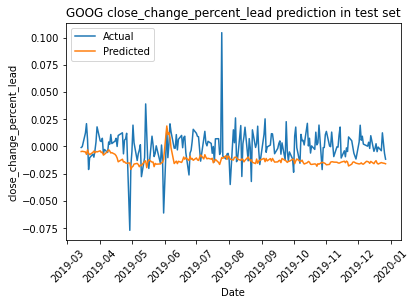

Ticker: GOOG


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105775.5346515494, tolerance: 12924.262171174154
  positive)


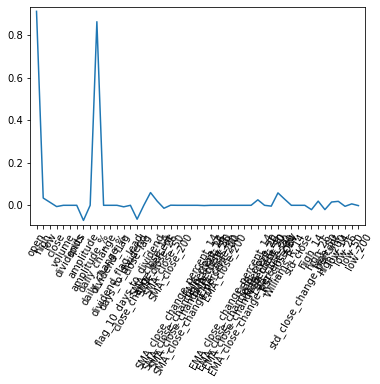

Int64Index([ 0,  1,  2,  3,  4,  7,  9, 13, 15, 17, 18, 19, 20, 25, 33, 35, 36,
            37, 38, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: low', 'Columns selected: close',
       'Columns selected: volume', 'Columns selected: amplitude',
       'Columns selected: daily_change', 'Columns selected: days_to_dividend',
       'Columns selected: close_lag', 'Columns selected: SMA_close_14',
       'Columns selected: SMA_close_26', 'Columns selected: SMA_close_50',
       'Columns selected: SMA_close_200', 'Columns selected: EMA_close_14',
       'Columns selected: UBB_close_20', 'Columns selected: LBB_close_20',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: high_14',
       'Columns selected: high_26', 'Columns selected: high_50',
       'Columns selected: high_200', 'Columns selected: low_14',
       'Colum

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.8510851004468462
 Forecast Accuracy (CV):  0.9459503471165843


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12062055179706778,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=19,
                      min_weight_fraction_leaf=0.0, n_estimators=91,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.999930025491998
[21:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3632998106825264,
             gamma=0.3776835725101465, importance_type='gain',
             learning_rate=0.25616509747102406, max_delta_step=0, max_dept

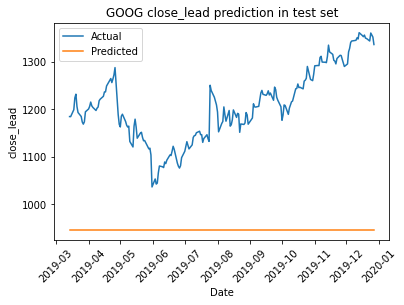

Ticker: GOOG


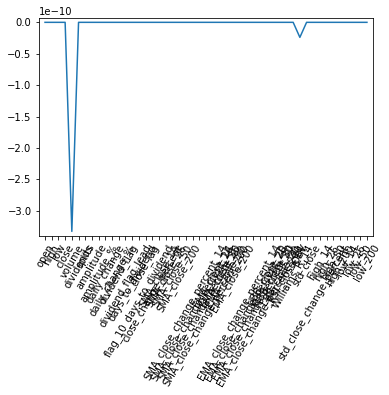

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9698342519054571
 Forecast Accuracy (CV):  0.9659144682120324


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.24076556126090504,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=57,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9792625945621688
 Forecast Accuracy (CV):  0.979343601198536


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9835044773622217
 Forecast Accuracy (CV):  0.9725784860832769
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

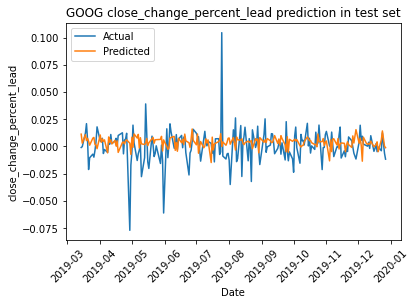

Ticker: GOOG


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9955409103668212
 Forecast Accuracy (CV):  0.9981883825719998
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.7609462518927563,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=17,
                      min_weight_fraction_leaf=0.0, n_estimators=148,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9937185962870745
 Forecast Accuracy (CV):  0.9988257665421844
[21:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byn

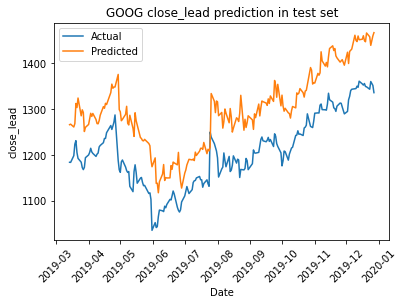

Ticker: GOOG


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.977710139550457
 Forecast Accuracy (CV):  0.9621935882268697
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=54,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9863388601629761
 Forecast Accuracy (CV):  0.9767628633475216


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9769685270304983
 Forecast Accuracy (CV):  0.9714927991578424
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.13938108160554977,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
         

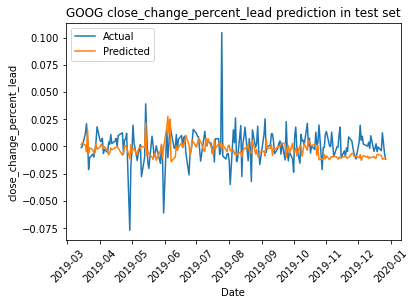

Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9910711244704644
 Forecast Accuracy (CV):  0.9852240071574323
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.10707224270853384,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=19,
                      min_weight_fraction_leaf=0.0, n_estimators=286,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.986081002775395
 Forecast Accuracy (CV):  0.9991828692143804
[21:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_by

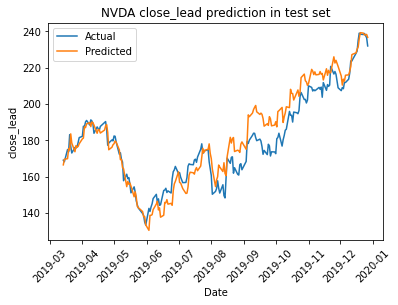

Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.988947916910399
 Forecast Accuracy (CV):  0.9250091302419268
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.7978265982532251,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=224,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9612378556818648
 Forecast Accuracy (CV):  0.9346086493291891
[21:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

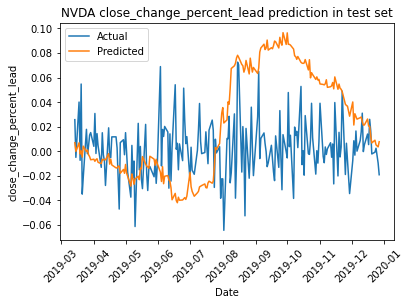

Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11064.331108259154, tolerance: 1209.1517689776827
  positive)


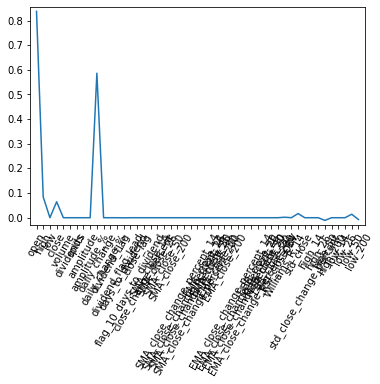

Int64Index([0, 1, 3, 4, 9, 13, 37, 38, 39, 43, 47, 48], dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: daily_change', 'Columns selected: days_to_dividend',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: std_close', 'Columns selected: high_50',
       'Columns selected: low_50', 'Columns selected: low_200'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9695401834778055
 Forecast Accuracy (CV):  0.9854212184207547
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features=0.7977270616632045,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.983621090237631
 Forecast Accuracy (CV):  0.9990516552482598
[21:14:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

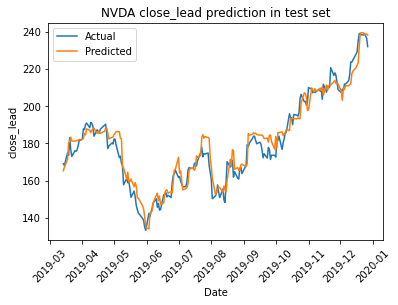

Ticker: NVDA


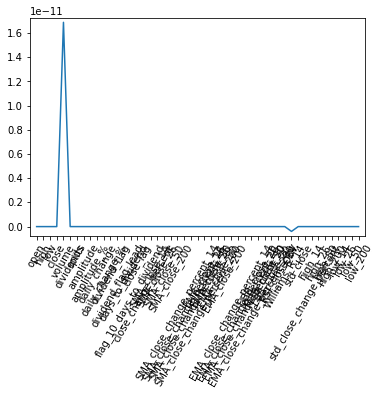

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9410112986764174
 Forecast Accuracy (CV):  0.927775645845707
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9676014259740872
 Forecast Accuracy (CV):  0.9291471017578774
[21:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0

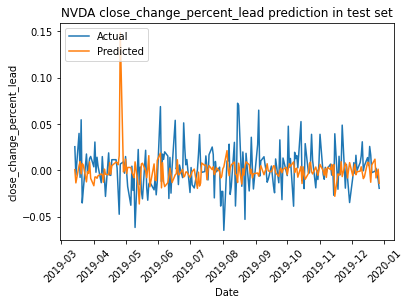

Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.999863024431755
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999901213161857
[21:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gam

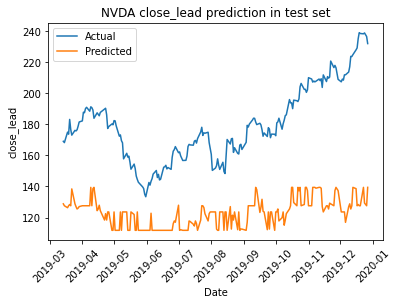

Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9512380253964429
 Forecast Accuracy (CV):  0.8843608775956868
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.4554839289144088,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9625231878527729
 Forecast Accuracy (CV):  0.9209248917187193
[21:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byno

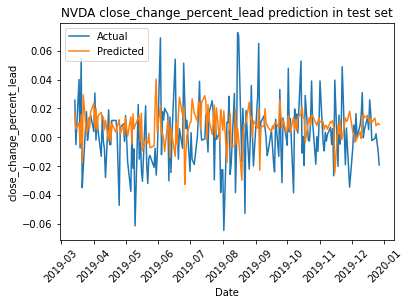

Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9937748358483701
 Forecast Accuracy (CV):  0.9955328274546427
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9972998313391503
 Forecast Accuracy (CV):  0.9999084573230362
[21:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynod

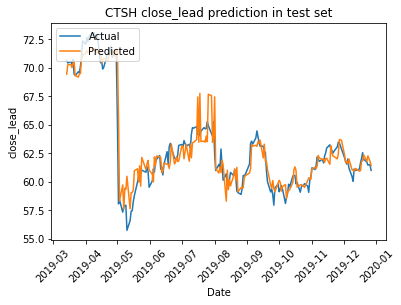

Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9835140702627104
 Forecast Accuracy (CV):  0.9673822646048879
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9921583794479885
 Forecast Accuracy (CV):  0.9733838438145368


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:24:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9928504209584508
 Forecast Accuracy (CV):  0.9742308671385604
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

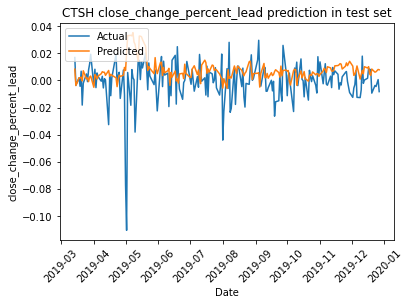

Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2393.6205322082615, tolerance: 37.570851409254416
  positive)


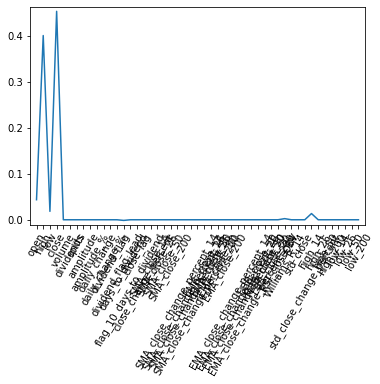

Int64Index([0, 1, 2, 3, 4, 13, 37, 38, 41], dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: low', 'Columns selected: close',
       'Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: high_14'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.99701444880322
 Forecast Accuracy (CV):  0.9945963701924578
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1, max_features=0.12802062690227559,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9979394772790232
 Forecast Accuracy (CV):  0.999624718488522
[21:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1

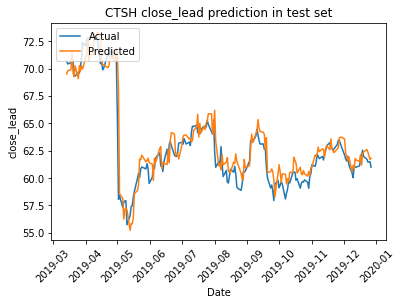

Ticker: CTSH


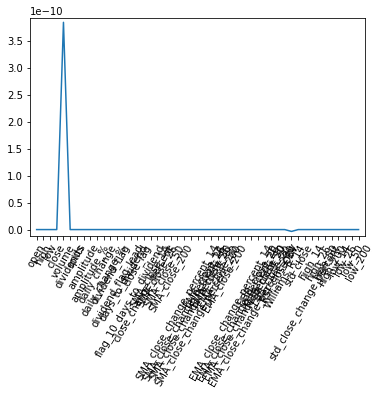

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9835039758684673
 Forecast Accuracy (CV):  0.9574033355446895
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features=0.7977270616632045,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9773157806517508
 Forecast Accuracy (CV):  0.9669960189136093


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9914829145160227
 Forecast Accuracy (CV):  0.9714671238608783
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

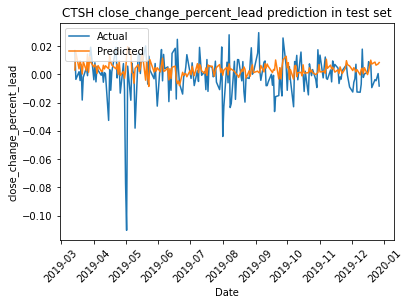

Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9998960010139768
 Forecast Accuracy (CV):  0.9998562575205018
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.7609462518927563,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=17,
                      min_weight_fraction_leaf=0.0, n_estimators=148,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9985275244297787
 Forecast Accuracy (CV):  0.9998716148260045
[21:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byn

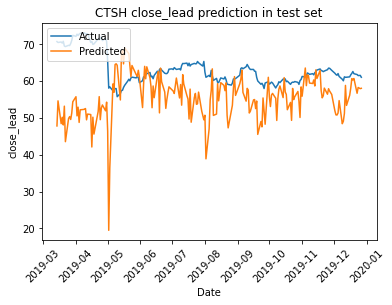

Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9889913647236972
 Forecast Accuracy (CV):  0.9591251442834235
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9920428769698508
 Forecast Accuracy (CV):  0.9670376825312534


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9935393714295939
 Forecast Accuracy (CV):  0.9666879386290314
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

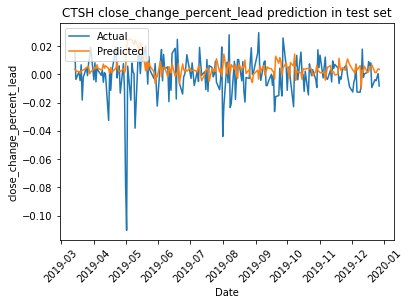

Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.985644965457862
 Forecast Accuracy (CV):  0.9893700760219224
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=0.10603012904901472,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=66,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9981484949114868
 Forecast Accuracy (CV):  0.996342270159401
[21:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=

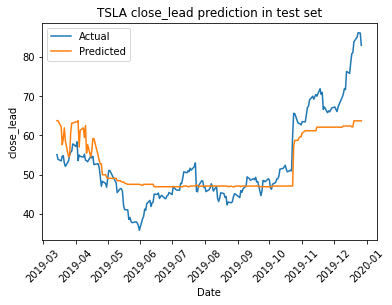

Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9589544603472052
 Forecast Accuracy (CV):  0.9008814285762567
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9408086655737489
 Forecast Accuracy (CV):  0.8960139428771707
[21:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,

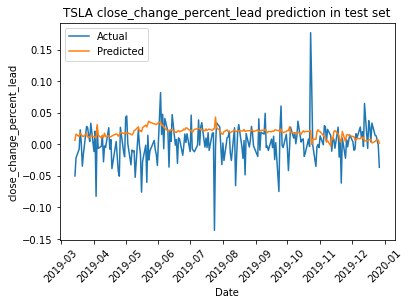

Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3344.7762920291443, tolerance: 75.18487488265906
  positive)


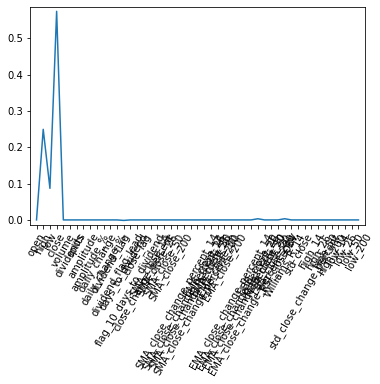

Int64Index([1, 2, 3, 4, 13, 33, 37, 38], dtype='int64')
Index(['Columns selected: high', 'Columns selected: low',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: days_to_dividend', 'Columns selected: UBB_close_20',
       'Columns selected: Williams_R_14', 'Columns selected: OBV'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9799540573361707
 Forecast Accuracy (CV):  0.9839798003910494
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=0.10603012904901472,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=66,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9979002311526215
 Forecast Accuracy (CV):  0.9988213383390201


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9947921114722629
 Forecast Accuracy (CV):  0.9946000809770544
Best model is:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=0.10603012904901472,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
            

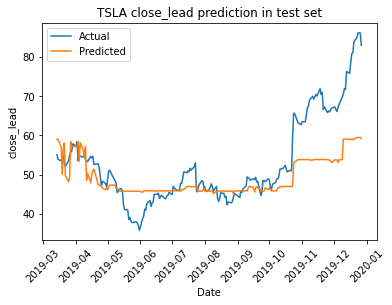

Ticker: TSLA


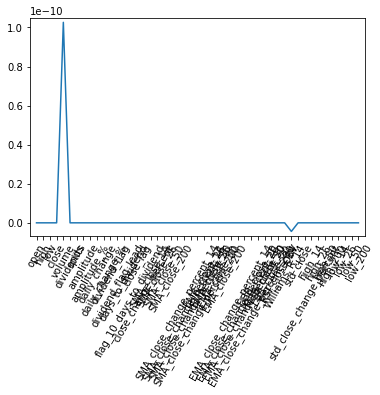

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9195279681086247
 Forecast Accuracy (CV):  0.8220981802683497
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.4554839289144088,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.946481850552913
 Forecast Accuracy (CV):  0.8802305566900934
[21:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynod

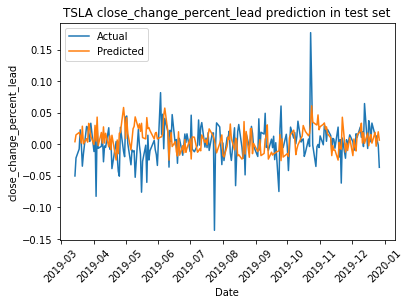

Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9989963961534903
 Forecast Accuracy (CV):  0.9997038854211299
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.2213370821940342,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=136,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  0.9972652761791426
 Forecast Accuracy (CV):  0.9987964114751136
[21:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_byn

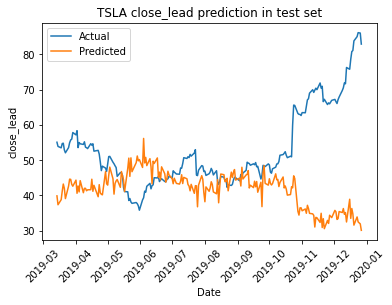

Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.8952680069129912
 Forecast Accuracy (CV):  0.8194239958018534
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9422033228352513
 Forecast Accuracy (CV):  0.861101137554141
[21:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0

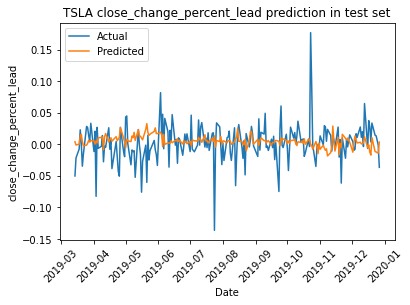

Ticker: M


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9955202548340236
 Forecast Accuracy (CV):  0.9944236406126395
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9986403153293159
 Forecast Accuracy (CV):  0.9975295999219486
[21:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3583267100

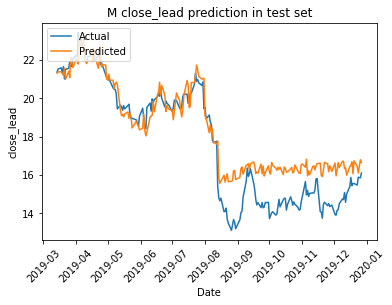

Ticker: M


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9341368788567626
 Forecast Accuracy (CV):  0.9363177300642987
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9830472537514059
 Forecast Accuracy (CV):  0.9455967731976656


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9871039592028994
 Forecast Accuracy (CV):  0.9573974154550235
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,


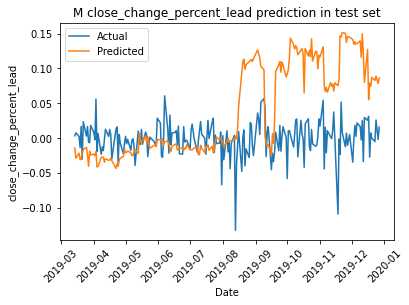

Ticker: M


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2026.1278445007397, tolerance: 15.064267204819442
  positive)


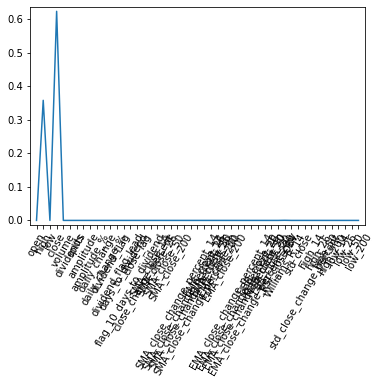

Int64Index([1, 3, 4, 37, 38], dtype='int64')
Index(['Columns selected: high', 'Columns selected: close',
       'Columns selected: volume', 'Columns selected: Williams_R_14',
       'Columns selected: OBV'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9957473571532672
 Forecast Accuracy (CV):  0.9943310418356031


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features=0.10603012904901472,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=66,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.99949492264383
[21:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.36599393977946615,
             gamma=0.1949942461380505, importance_type='gain',
             learning_rate=0.22469369385521204, max_delta_step=0, max_depth

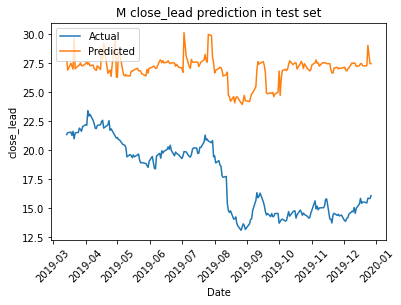

Ticker: M


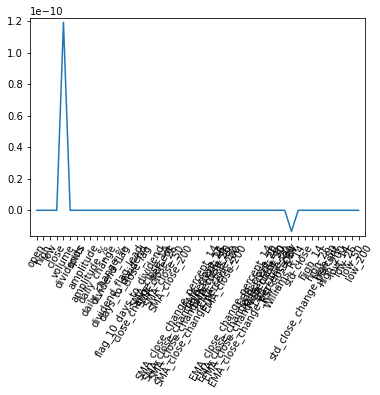

Int64Index([4, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: OBV'], dtype='object')


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
 Forecast Accuracy:  0.9560578705628312
 Forecast Accuracy (CV):  0.9284212119957481
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9688219433966001
 Forecast Accuracy (CV):  0.9291469713590319


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9701375251749518
 Forecast Accuracy (CV):  0.9471243294846263
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100

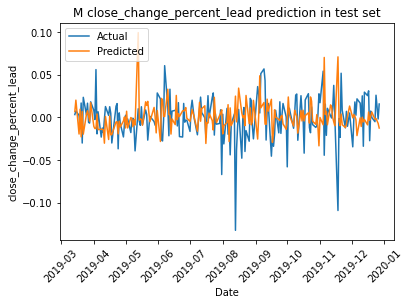

Ticker: M


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9999907997953971
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=0.5303791606476355,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=248,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
 Forecast Accuracy:  1.0
 Forecast Accuracy (CV):  0.9993494906231317
[21:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.36599

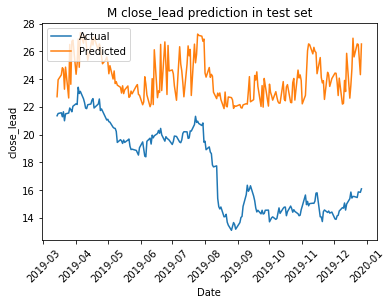

Ticker: M


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
 Forecast Accuracy:  0.9545743590629532
 Forecast Accuracy (CV):  0.9322845852464806
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
 Forecast Accuracy:  0.9731830929061104
 Forecast Accuracy (CV):  0.9495771492199355


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[21:49:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
 Forecast Accuracy:  0.9760912586319878
 Forecast Accuracy (CV):  0.9416682256995023
Best model is:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=7, missing=None, n_estimators=1

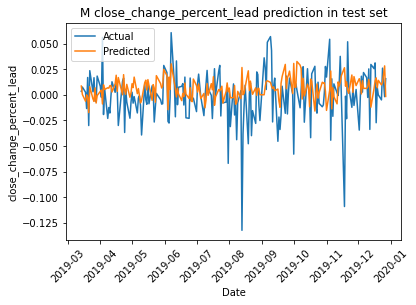

   ticker   preprocessing  ...   best_FA cv_score_in_best
0     AAL    All features  ...  0.999156         0.996823
1     AAL    All features  ...  0.981330         0.937841
2     AAL  LASSO features  ...  0.999989         0.998216
3     AAL  LASSO features  ...  0.976231         0.913027
4     AAL    PCA features  ...  0.999992         0.999370
5     AAL    PCA features  ...  0.976553         0.911173
6    MSFT    All features  ...  1.000000         0.999470
7    MSFT    All features  ...  0.999632         0.974232
8    MSFT  LASSO features  ...  1.000000         0.999653
9    MSFT  LASSO features  ...  0.994009         0.973512
10   MSFT    PCA features  ...  1.000000         0.999979
11   MSFT    PCA features  ...  0.992055         0.977404
12   AAPL    All features  ...  0.998881         0.999326
13   AAPL    All features  ...  0.988961         0.966355
14   AAPL  LASSO features  ...  1.000000         0.999382
15   AAPL  LASSO features  ...  0.988274         0.967107
16   AAPL    P

In [ ]:
i = 0
for s in stocks:
    # Modelos para precio de cierre
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_model_reg (regressors, label='close_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'All features','label': label,'features': "all",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'All features','label': label,'features': "all",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1
    # Modelos para % de cambio en el precio de cierre
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_model_reg (regressors, label='close_change_percent_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'All features', 'label': label,'features': "all",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'All features', 'label': label,'features': "all",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1
    # Modelos para precio de cierre usando solo los features obtenidos con LASSO
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_model_reg_features (regressors, label='close_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'LASSO features', 'label': label,'features': "LASSO features",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'LASSO features', 'label': label,'features': "LASSO features",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1
    # Modelos para % de cambio en el precio de cierre usando solo los features obtenidos con LASSO
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_model_reg_features (regressors, label='close_change_percent_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'LASSO features', 'label': label,'features': "LASSO features",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'LASSO features', 'label': label,'features': "LASSO features",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1
    # Modelos para precio de cierre usando PCA
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_pca_model_reg (regressors, label='close_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'PCA features', 'label': label,'features': "PCA",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'PCA features', 'label': label,'features': "PCA",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1
    # Modelos para % de cambio en el precio de cierre usando PCA
    ticker, label, best_regressor, best_FA, cv_scores_mean = best_pca_model_reg (regressors, label='close_change_percent_lead',train_size=0.9,test_size=0.1,ticker=s,df=df)
    #aux_models_df = pd.DataFrame({'ticker': ticker, 'preprocessing': 'PCA features', 'label': label,'features': "PCA",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean}, index=[i])
    models_df = models_df.append({'ticker': ticker, 'preprocessing': 'PCA features', 'label': label,'features': "PCA",'best_model': best_regressor, 'best_FA': best_FA, 'cv_score_in_best': cv_scores_mean},ignore_index=True)
    i = i + 1

print(models_df)
models_df.to_csv(path_or_buf='best_regression_models.csv')

In [ ]:
! zip reg_models.zip *.sav

  adding: AAL_close_change_percent_lead_allfeatures.sav (deflated 53%)
  adding: AAL_close_change_percent_lead_lassofeatures.sav (deflated 57%)
  adding: AAL_close_change_percent_lead_subsetfeatures.sav (deflated 58%)
  adding: AAL_close_lead_allfeatures.sav (deflated 65%)
  adding: AAL_close_lead_lassofeatures.sav (deflated 19%)
  adding: AAL_close_lead_subsetfeatures.sav (deflated 70%)
  adding: AAPL_close_change_percent_lead_allfeatures.sav (deflated 6%)
  adding: AAPL_close_change_percent_lead_lassofeatures.sav (deflated 58%)
  adding: AAPL_close_change_percent_lead_subsetfeatures.sav (deflated 69%)
  adding: AAPL_close_lead_allfeatures.sav (deflated 69%)
  adding: AAPL_close_lead_lassofeatures.sav (deflated 56%)
  adding: AAPL_close_lead_subsetfeatures.sav (deflated 70%)
  adding: AMZN_close_change_percent_lead_allfeatures.sav (deflated 61%)
  adding: AMZN_close_change_percent_lead_lassofeatures.sav (deflated 58%)
  adding: AMZN_close_change_percent_lead_subsetfeatures.sav (deflat

## Backtesting de estrategias

En una primer instancia se utilizará una estrategia Naive como benchmark, en la cual se compran acciones el primer días y se venden el último. Esta estrategia luego servirá para comparar la performance del resto.
Las 3 estrategias diseñadas utilizan diferentes modelos de Machine Learning con diferentes variables objetivo como labels. Para cada acción se busca el mejor modelo de predicción de cada label, y se utiliza éste para realizar el backtesting.
En la primer estrategia se compara el precio de cierre con la predicción del precio de cierre del día siguiente, utilizando un margen de cobertura mínimo definido como parámetro arbitrario.
Dado que lo que se evalúa realmente es el cambio porcentual a la hora de tomar la decisión de realizar una operación, la segunda estrategia se basa en predecir directamente ese cambio porcentual.
Por último, la tercer estrategia se basa en realizar dos clasificaciones binarias para tomar la decisión de compra o venta, teniendo como label una variable que marca si el cambio porcentual será por encima/debajo del margen de cobertura o no.

In [ ]:
# Benchmark para el backtesting (compro el primer día y vendo el último)
backtesting_column_names = ["ticker","estrategia","best_model","date","prediccion", "precio_cierre", "valor_cartera","cantidad_compra","cantidad_venta","tenencia_acciones","invertido","cash","comisiones_pagadas","status"]
backtesting_df = pd.DataFrame(columns = backtesting_column_names)
ganancias_backtesting_column_names = ["ticker","estrategia","ganancia","ganancia_porcentual","volatilidad","sharpe_ratio"]
ganancias_backtesting_df = pd.DataFrame(columns = ganancias_backtesting_column_names)

In [ ]:
def backtesting_naive(backtesting_df,ganancias_backtesting_df,ticker,comision,margen_cobertura,monto_inversion,fecha_inicio,fecha_fin):
    i = 0
    print('Ticker: ',ticker)
    # Defino parámetros básicos
    status = 'cash'
    cash = monto_inversion
    invertido = 0
    tenencia_acciones = 0
    valor_cartera = cash + invertido
    comisiones_pagadas = 0
    # Manipulación primaria
    fechas = df.loc[(df.index.get_level_values('date') >=fecha_inicio) & (df.index.get_level_values('date') <= fecha_fin) & (df.index.get_level_values('ticker')==ticker)].index.get_level_values('date').tolist()
    for f in fechas:
        cantidad_compra = 0
        cantidad_venta = 0
        index = fechas.index(f)
        precio_cierre = df.loc[(df.index.get_level_values('ticker')==ticker) & (df.index.get_level_values('date') == f)]['close'].values[0]
        # Tomo decisión de inversión
        if (index==0):
            cantidad_compra = int(cash/(precio_cierre*(1+comision)))
            tenencia_acciones += cantidad_compra
            invertido += cantidad_compra*precio_cierre
            cash -=cantidad_compra*precio_cierre*(1+comision)
            comisiones_pagadas += cantidad_compra*precio_cierre*comision
            status = 'invertido'
            print('Se compraron ',cantidad_compra,' acciones de ',ticker,' a un precio de ',precio_cierre)
        # Actualizo valor de la cartera en el día
        invertido = tenencia_acciones*precio_cierre
        valor_cartera = cash + invertido
        print('Al dia ',f,' el valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
        # Hacer tracking dia a dia de las operaciones y de los saldos de cash e invertido 
        prediccion = 0
        aux_backtesting_df = pd.DataFrame({'ticker': ticker, 'estrategia' : 'Compro primer dia y vendo el ultimo','best_model': 'Naive','date': f, 'prediccion': prediccion, 'precio_cierre': precio_cierre, 'valor_cartera': valor_cartera, 'cantidad_compra': cantidad_compra, 'cantidad_venta': cantidad_venta, 'tenencia_acciones': tenencia_acciones, 'invertido': invertido,'cash': cash,'comisiones_pagadas': comisiones_pagadas,'status': status}, index=[i])
        backtesting_df = backtesting_df.append(aux_backtesting_df, ignore_index=True)
        i = i + 1
    #Vendo todo lo que quedó invertido
    cantidad_venta = tenencia_acciones
    tenencia_acciones -= cantidad_venta
    invertido -= cantidad_venta*precio_cierre
    cash += cantidad_venta*precio_cierre*(1-comision)
    comisiones_pagadas += cantidad_venta*precio_cierre*comision
    status = 'cash'
    print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_cierre)
    invertido = tenencia_acciones*precio_cierre
    valor_cartera = cash + invertido
    ganancia = valor_cartera-monto_inversion
    ganancia_porcentual = ganancia/monto_inversion*100
    retornos_diarios = backtesting_df.loc[(backtesting_df['ticker']==ticker) & (backtesting_df['estrategia']=='Compro primer dia y vendo el ultimo')]['valor_cartera'].pct_change(1)
    retornos_diarios = retornos_diarios.loc[pd.notnull(retornos_diarios)]
    volatilidad = 100 * retornos_diarios.values.std()
    sharpe_ratio = (ganancia_porcentual-0)/volatilidad
    print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
    print('El valor final de la cartera es ',valor_cartera,', con una ganancia del ',ganancia_porcentual, '% para el ticker ',ticker, ' logrando un SHARPE Ratio de ', sharpe_ratio)
    ganancias_backtesting_df = ganancias_backtesting_df.append({'ticker' : ticker , 'estrategia' : 'Compro primer dia y vendo el ultimo', 'ganancia': ganancia,'ganancia_porcentual': ganancia_porcentual,'volatilidad': volatilidad, 'sharpe_ratio': sharpe_ratio}, ignore_index=True)
    return backtesting_df, ganancias_backtesting_df

In [ ]:
for ticker in stocks:
  backtesting_df, ganancias_backtesting_df = backtesting_naive(backtesting_df=backtesting_df,ganancias_backtesting_df=ganancias_backtesting_df,ticker=ticker,comision=0.005,margen_cobertura=0.01,monto_inversion=10000,fecha_inicio='2019-01-01',fecha_fin='2019-12-27')
print(ganancias_backtesting_df)

Ticker:  AAL
Se compraron  311  acciones de  AAL  a un precio de  31.963159561157227
Al dia  2019-01-02 00:00:00  el valor de la cartera es:  9950.297286882402 . Cash:  9.754663362504289  , Invertido:  9940.542623519897
Al dia  2019-01-03 00:00:00  el valor de la cartera es:  9209.652490510942 . Cash:  9.754663362504289  , Invertido:  9199.897827148438
Al dia  2019-01-04 00:00:00  el valor de la cartera es:  9815.63470448494 . Cash:  9.754663362504289  , Invertido:  9805.880041122437
Al dia  2019-01-07 00:00:00  el valor de la cartera es:  10094.140600099565 . Cash:  9.754663362504289  , Invertido:  10084.38593673706
Al dia  2019-01-08 00:00:00  el valor de la cartera es:  9931.932859315873 . Cash:  9.754663362504289  , Invertido:  9922.17819595337
Al dia  2019-01-09 00:00:00  el valor de la cartera es:  10237.984506502153 . Cash:  9.754663362504289  , Invertido:  10228.229843139648
Al dia  2019-01-10 00:00:00  el valor de la cartera es:  9815.63470448494 . Cash:  9.754663362504289  , 

In [ ]:
from datetime import datetime
import ast
def preparacion_backtesting(ticker,fecha_inicio,fecha_fin,mod,num_train, label):
    print('Ticker: ',ticker)
    # Manipulación primaria
    train = df.loc[(df.index.get_level_values('date') >= datetime.strptime(fecha_inicio,'%Y-%m-%d')-timedelta(days=num_train)) & (df.index.get_level_values('date') < fecha_inicio) & (df.index.get_level_values('ticker')==ticker)]
    train = train.fillna(method='bfill')
    if label=='close_change_percent_lead_flag':
      label_columns = ['open_lead','close_change_percent_lead','close_lead','close_change_percent_lead_flag','close_change_percent_lead_up_flag','close_change_percent_lead_down_flag']
    else:
      label_columns = ['open_lead','close_change_percent_lead','close_lead']
    X_train = train.copy().drop(columns=label_columns).values
    y_train = train.copy()[label].values
    dates_train = train.index.get_level_values('date')
    test = df.loc[(df.index.get_level_values('date') >=fecha_inicio) & (df.index.get_level_values('date') <= fecha_fin) & (df.index.get_level_values('ticker')==ticker)]
    test = test.fillna(method='bfill')
    X_pred = test.copy().drop(columns=label_columns).values
    print('Test columns: ',test.copy().drop(columns=label_columns).columns)
    # Busco cual es el preprocesamiento que debo hacer
    if (mod[1]['preprocessing'] == 'LASSO features'):
        # Uso modelo con features LASSO
        if label=='close_change_percent_lead_flag':
          lasso = LogisticRegression(fit_intercept=False,penalty='l1', solver='liblinear', C=0.01)
          lasso.fit(X_train,y_train)
          lasso_coef = lasso.coef_[0]
        else:
          lasso=Lasso()
          lasso.fit(X_train,y_train)
          lasso_coef = lasso.coef_
        columns = list(train.copy().drop(columns=label_columns).columns.values)
        reg_coef = pd.DataFrame({'feature':columns,'lasso_coef':lasso_coef})
        indexes = reg_coef['feature'][(reg_coef['lasso_coef']>0)|(reg_coef['lasso_coef']<0)].index
        indexes = list(indexes)
        X_train = X_train[:,indexes]
        X_pred = X_pred[:,indexes]
        print('Test columns: ', columns)
    elif (mod[1]['preprocessing'] == 'PCA features'):
        # Uso modelo con features PCA
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_mean.fit(X_train)
        X_train = imp_mean.transform(X_train)
        scaler = StandardScaler()
        pca = PCA(n_components=3)
        pipeline = make_pipeline(scaler,pca)
        pipeline.fit(X_train)
        X_train = pipeline.transform(X_train)
        imp_mean.fit(X_pred)
        X_pred = imp_mean.transform(X_pred)
        X_pred = pipeline.transform(X_pred)
        print('Modelo con PCA')
    # Entreno el mejor modelo
    filename = mod[1]['best_model']
    print(filename)
    model = pickle.load(open(filename, 'rb'))
    print(model)
    #model.fit(X_train, y_train)
    # Genero una predicción
    try:
      y_pred = model.predict(X_pred)
    except:
      print('Model couldnt run')
      y_pred = np.zeros(X_pred.shape[0])
    return y_pred, model


In [ ]:
# Backtesting para modelo de predicción de precio al cierre
from datetime import timedelta
def backtesting_prediccion_precio(mod, backtesting_df,ganancias_backtesting_df,ticker,comision,margen_cobertura,monto_inversion,fecha_inicio,fecha_fin,num_train):
    i=0
    y_pred, regressor = preparacion_backtesting(ticker,fecha_inicio,fecha_fin,mod,num_train, label='close_lead')
    # Defino parámetros básicos
    status = 'cash'
    cash = monto_inversion
    invertido = 0
    tenencia_acciones = 0
    valor_cartera = cash + invertido
    comisiones_pagadas = 0
    # Simulación de la estrategia
    fechas = df.loc[(df.index.get_level_values('date') >=fecha_inicio) & (df.index.get_level_values('date') <= fecha_fin) & (df.index.get_level_values('ticker')==ticker)].index.get_level_values('date').tolist()
    for f in fechas:
        cantidad_compra = 0
        cantidad_venta = 0
        # Genero conjuntos de train y de predicción
        index = fechas.index(f)
        prediccion = y_pred[index]
        precio_cierre = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['close'].values[0]
        precio_apertura_siguiente = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['open_lead'].values[0] 
        print(f,'. Predicción Cierre Siguiente= ',prediccion,' Precio Cierre Actual= ',precio_cierre, ' Precio Apertura Siguiente= ',precio_apertura_siguiente)
        # Tomo decisión de inversión
        if f<fechas[-1]:
          if (prediccion>=precio_apertura_siguiente and prediccion>=precio_cierre*(margen_cobertura+1) and status == 'cash'):
              cantidad_compra = int(cash/(precio_apertura_siguiente*(1+comision)))
              tenencia_acciones += cantidad_compra
              invertido += cantidad_compra*precio_apertura_siguiente
              cash -=cantidad_compra*precio_apertura_siguiente*(1+comision)
              comisiones_pagadas += cantidad_compra*precio_apertura_siguiente*comision
              status = 'invertido'
              print('Se compraron ',cantidad_compra,' acciones a un precio de ',precio_apertura_siguiente)
          elif (prediccion<=precio_apertura_siguiente and prediccion<=precio_cierre*(1-margen_cobertura) and status == 'invertido'):   
              cantidad_venta = tenencia_acciones
              tenencia_acciones -= cantidad_venta
              invertido -= cantidad_venta*precio_apertura_siguiente
              cash += cantidad_venta*precio_apertura_siguiente*(1-comision)
              comisiones_pagadas += cantidad_venta*precio_apertura_siguiente*comision
              status = 'cash'
              print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_apertura_siguiente)
        # Actualizo valor de la cartera en el día (al principio del día en el momento de la compra/venta)
        if f<fechas[-1]:
          invertido = tenencia_acciones*precio_apertura_siguiente
        else:
          #Vendo todo lo que quedó invertido
          cantidad_venta = tenencia_acciones
          tenencia_acciones -= cantidad_venta
          invertido -= cantidad_venta*precio_cierre
          cash += cantidad_venta*precio_cierre*(1-comision)
          comisiones_pagadas += cantidad_venta*precio_cierre*comision
          status = 'cash'
          print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_cierre)
          invertido = tenencia_acciones*precio_cierre
        valor_cartera = cash + invertido
        print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
        # Hacer tracking dia a dia de las operaciones y de los saldos de cash e invertido 
        aux_backtesting_df = pd.DataFrame({'ticker': ticker, 'estrategia' : 'Prediccion del precio al cierre','best_model': str(regressor),'date': f, 'prediccion': prediccion, 'precio_cierre': precio_cierre, 'valor_cartera': valor_cartera, 'cantidad_compra': cantidad_compra, 'cantidad_venta': cantidad_venta, 'tenencia_acciones': tenencia_acciones, 'invertido': invertido,'cash': cash,'comisiones_pagadas': comisiones_pagadas,'status': status}, index=[i])
        backtesting_df = backtesting_df.append(aux_backtesting_df,ignore_index=True)
        i = i + 1
        

    ganancia = valor_cartera-monto_inversion
    ganancia_porcentual = ganancia/monto_inversion*100
    retornos_diarios = backtesting_df.loc[(backtesting_df['ticker']==ticker) & (backtesting_df['estrategia']=='Compro primer dia y vendo el ultimo')]['valor_cartera'].pct_change(1)
    retornos_diarios = retornos_diarios.loc[pd.notnull(retornos_diarios)]
    volatilidad = 100 * retornos_diarios.values.std()
    sharpe_ratio = (ganancia_porcentual-0)/volatilidad
    print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
    print('El valor final de la cartera es ',valor_cartera,', con una ganancia del ',ganancia_porcentual, '% para el ticker ',ticker, ' logrando un SHARPE Ratio de ', sharpe_ratio)
    ganancias_backtesting_df = ganancias_backtesting_df.append({'ticker' : ticker , 'estrategia' : 'Prediccion del precio al cierre', 'ganancia': ganancia,'ganancia_porcentual': ganancia_porcentual,'volatilidad': volatilidad, 'sharpe_ratio': sharpe_ratio}, ignore_index=True)
    return backtesting_df, ganancias_backtesting_df

In [ ]:
models_df = pd.read_csv('best_regression_models.csv',index_col=0)
for ticker in stocks:
  models = models_df.loc[(models_df['ticker'] == ticker) & (models_df['label'] == 'close_lead')]
  for mod in models.iterrows():
    backtesting_df, ganancias_backtesting_df = backtesting_prediccion_precio(mod=mod, backtesting_df=backtesting_df,ganancias_backtesting_df=ganancias_backtesting_df,ticker=ticker,comision=0.005,margen_cobertura=0.01,monto_inversion=10000,fecha_inicio='2019-01-01',fecha_fin='2019-12-27',num_train=1760)
print(ganancias_backtesting_df)

Ticker:  AAL
Test columns:  Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits',
       'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%',
       'dividend_flag', 'dividend_flag_lead', 'days_to_dividend',
       'flag_10_days_to_dividend', 'close_lag', 'close_change_percent',
       'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200',
       'SMA_close_change_percent_14', 'SMA_close_change_percent_26',
       'SMA_close_change_percent_50', 'SMA_close_change_percent_200',
       'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200',
       'EMA_close_change_percent_14', 'EMA_close_change_percent_26',
       'EMA_close_change_percent_50', 'EMA_close_change_percent_200',
       'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14',
       'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent',
       'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26',
       'low_50', 'low_200'],
      dtype='object')
AAL_c

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.77082539316575, tolerance: 4.393912501340492
  positive)


2019-01-11 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  31.29397964477539  Precio Apertura Siguiente=  30.900343440592255
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  31.20541000366211  Precio Apertura Siguiente=  31.37270623078836
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-15 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  31.589204788208008  Precio Apertura Siguiente=  32.29774639147015
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-16 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  32.31742858886719  Precio Apertura Siguiente=  32.22886001220521
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-17 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  33.045654296875  Precio Apertura Siguiente=  33.3015185725

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1814.9476637101611, tolerance: 61.44622819407901
  positive)


Test columns:  ['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits', 'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%', 'dividend_flag', 'dividend_flag_lead', 'days_to_dividend', 'flag_10_days_to_dividend', 'close_lag', 'close_change_percent', 'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200', 'SMA_close_change_percent_14', 'SMA_close_change_percent_26', 'SMA_close_change_percent_50', 'SMA_close_change_percent_200', 'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200', 'EMA_close_change_percent_14', 'EMA_close_change_percent_26', 'EMA_close_change_percent_50', 'EMA_close_change_percent_200', 'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14', 'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent', 'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26', 'low_50', 'low_200']
MSFT_close_lead_subsetfeatures.sav
[23:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1348.3990831078336, tolerance: 10.41164774532704
  positive)


2019-01-08 00:00:00 . Predicción Cierre Siguiente=  36.10094637388303  Precio Cierre Actual=  36.51277160644531  Precio Apertura Siguiente=  36.64356009088182
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-09 00:00:00 . Predicción Cierre Siguiente=  35.91311229773652  Precio Cierre Actual=  37.13282012939453  Precio Apertura Siguiente=  36.9366401615487
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-10 00:00:00 . Predicción Cierre Siguiente=  36.10094637388303  Precio Cierre Actual=  37.25151062011719  Precio Apertura Siguiente=  37.0286779162406
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-11 00:00:00 . Predicción Cierre Siguiente=  36.10094637388303  Precio Cierre Actual=  36.885772705078125  Precio Apertura Siguiente=  36.536997359715556
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  36.10094637388303  Precio Cierre

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220665.388380248, tolerance: 27680.832806528124
  positive)


Test columns:  ['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits', 'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%', 'dividend_flag', 'dividend_flag_lead', 'days_to_dividend', 'flag_10_days_to_dividend', 'close_lag', 'close_change_percent', 'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200', 'SMA_close_change_percent_14', 'SMA_close_change_percent_26', 'SMA_close_change_percent_50', 'SMA_close_change_percent_200', 'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200', 'EMA_close_change_percent_14', 'EMA_close_change_percent_26', 'EMA_close_change_percent_50', 'EMA_close_change_percent_200', 'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14', 'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent', 'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26', 'low_50', 'low_200']
AMZN_close_lead_subsetfeatures.sav
[23:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8812.35840898149, tolerance: 909.6523347378902
  positive)


2019-01-11 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  342.9118347167969  Precio Apertura Siguiente=  338.3448559619621
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  340.4436950683594  Precio Apertura Siguiente=  342.03731004487884
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-15 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  342.2705078125  Precio Apertura Siguiente=  342.5230994732974
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-16 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  342.0955505371094  Precio Apertura Siguiente=  340.8226871667332
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-17 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  348.9266357421875  Precio Apertura Siguiente=  353.58106466249

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88635.7302013543, tolerance: 5617.59741061218
  positive)


2019-01-11 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  1057.18994140625  Precio Apertura Siguiente=  1046.9200439453125
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  1044.68994140625  Precio Apertura Siguiente=  1050.1700439453125
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-15 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  1077.1500244140625  Precio Apertura Siguiente=  1080.0
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-16 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  1080.969970703125  Precio Apertura Siguiente=  1079.469970703125
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-17 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  1089.9000244140625  Precio Apertura Siguiente=  1100.0
El valor de la 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9438.242885425403, tolerance: 911.2659584306014
  positive)


2019-01-08 00:00:00 . Predicción Cierre Siguiente=  142.29491439860004  Precio Cierre Actual=  139.09765625  Precio Apertura Siguiente=  141.1568054986754
El valor de la cartera es:  10779.100531093593 . Cash:  51.183313194262155  , Invertido:  10727.91721789933
2019-01-09 00:00:00 . Predicción Cierre Siguiente=  143.20868299116705  Precio Cierre Actual=  141.833251953125  Precio Apertura Siguiente=  141.05736190037734
El valor de la cartera es:  10771.54281762294 . Cash:  51.183313194262155  , Invertido:  10720.359504428678
2019-01-10 00:00:00 . Predicción Cierre Siguiente=  146.92065637001173  Precio Cierre Actual=  144.46939086914062  Precio Apertura Siguiente=  143.5740752844899
El valor de la cartera es:  10962.813034815495 . Cash:  51.183313194262155  , Invertido:  10911.629721621233
2019-01-11 00:00:00 . Predicción Cierre Siguiente=  149.4158751862438  Precio Cierre Actual=  148.05050659179688  Precio Apertura Siguiente=  145.9515514723621
El valor de la cartera es:  11143.50122

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1653.0635447472573, tolerance: 11.934056055531546
  positive)


2019-01-07 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  62.14778518676758  Precio Apertura Siguiente=  62.80247994649577
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-08 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  62.851341247558594  Precio Apertura Siguiente=  63.14449749175983
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-09 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  62.79271697998047  Precio Apertura Siguiente=  62.186867730660346
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-10 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  63.33015060424805  Precio Apertura Siguiente=  63.30082702427272
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-11 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  63.43762969970703  Precio Apertura Siguiente=  62.98814604

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2469.6725184310026, tolerance: 14.39326330288439
  positive)


 , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  66.87999725341797  Precio Apertura Siguiente=  67.0
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-15 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  68.88600158691406  Precio Apertura Siguiente=  68.95600128173828
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-16 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  69.20999908447266  Precio Apertura Siguiente=  69.24199676513672
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-17 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  69.46199798583984  Precio Apertura Siguiente=  64.5999984741211
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-18 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  60.45199966430664  Precio Apertura Siguiente=  60.96400

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239.06041461404, tolerance: 13.185241094969316
  positive)


2019-01-11 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  22.54383087158203  Precio Apertura Siguiente=  22.357586484054345
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-14 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  22.24229621887207  Precio Apertura Siguiente=  22.18022027498147
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-15 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  22.153614044189453  Precio Apertura Siguiente=  21.807740488135938
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-16 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  21.710186004638672  Precio Apertura Siguiente=  21.532815689076827
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-01-17 00:00:00 . Predicción Cierre Siguiente=  0.0  Precio Cierre Actual=  21.949636459350586  Precio Apertura Siguiente=  22.0915

In [ ]:
# Backtesting para modelo de predicción de cambio porcentual de precio al cierre
def backtesting_prediccion_cambio(mod, backtesting_df,ganancias_backtesting_df,ticker,comision,margen_cobertura,monto_inversion,fecha_inicio,fecha_fin,num_train):
    i=0
    y_pred, regressor = preparacion_backtesting(ticker,fecha_inicio,fecha_fin,mod,num_train, label='close_change_percent_lead')
    # Defino parámetros básicos
    status = 'cash'
    cash = monto_inversion
    invertido = 0
    tenencia_acciones = 0
    valor_cartera = cash + invertido
    comisiones_pagadas = 0
    # Simulación de la estrategia
    fechas = df.loc[(df.index.get_level_values('date') >=fecha_inicio) & (df.index.get_level_values('date') <= fecha_fin) & (df.index.get_level_values('ticker')==ticker)].index.get_level_values('date').tolist()
    for f in fechas:
        cantidad_compra = 0
        cantidad_venta = 0
        # Genero conjuntos de train y de predicción
        index = fechas.index(f)     
        prediccion = y_pred[index]
        precio_cierre = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['close'].values[0] 
        precio_apertura_siguiente = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['open_lead'].values[0] 
        prediccion_precio = (1+prediccion)*precio_cierre
        print(f,'. Predicción Cierre Siguiente= ',prediccion_precio,' Precio Cierre Actual= ',precio_cierre, ' Precio Apertura Siguiente= ',precio_apertura_siguiente)
        # Tomo decisión de inversión
        if f<fechas[-1]:
          if (prediccion_precio>precio_apertura_siguiente and prediccion>=0 and prediccion>=margen_cobertura and status == 'cash'):
              cantidad_compra = int(cash/(precio_apertura_siguiente*(1+comision)))
              tenencia_acciones += cantidad_compra
              invertido += cantidad_compra*precio_apertura_siguiente
              cash -=cantidad_compra*precio_apertura_siguiente*(1+comision)
              comisiones_pagadas += cantidad_compra*precio_apertura_siguiente*comision
              status = 'invertido'
              print('Se compraron ',cantidad_compra,' acciones a un precio de ',precio_apertura_siguiente)
          elif (prediccion_precio<precio_apertura_siguiente and prediccion<=0 and prediccion<=-margen_cobertura and status == 'invertido'):   
              cantidad_venta = tenencia_acciones
              tenencia_acciones -= cantidad_venta
              invertido -= cantidad_venta*precio_apertura_siguiente
              cash += cantidad_venta*precio_apertura_siguiente*(1-comision)
              comisiones_pagadas += cantidad_venta*precio_apertura_siguiente*comision
              status = 'cash'
              print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_apertura_siguiente)
        # Actualizo valor de la cartera en el día (al principio del día siguiente en el momento de la compra/venta)
        if f<fechas[-1]:
          invertido = tenencia_acciones*precio_apertura_siguiente
        else:
          #Vendo todo lo que quedó invertido
          cantidad_venta = tenencia_acciones
          tenencia_acciones -= cantidad_venta
          invertido -= cantidad_venta*precio_cierre
          cash += cantidad_venta*precio_cierre*(1-comision)
          comisiones_pagadas += cantidad_venta*precio_cierre*comision
          status = 'cash'
          print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_cierre)
          invertido = tenencia_acciones*precio_cierre
        valor_cartera = cash + invertido
        print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
        # Hacer tracking dia a dia de las operaciones y de los saldos de cash e invertido 
        aux_backtesting_df = pd.DataFrame({'ticker': ticker, 'estrategia' : 'Prediccion del % de cambio del precio al cierre','best_model': str(regressor),'date': f, 'prediccion': prediccion_precio, 'precio_cierre': precio_cierre, 'valor_cartera': valor_cartera, 'cantidad_compra': cantidad_compra, 'cantidad_venta': cantidad_venta, 'tenencia_acciones': tenencia_acciones, 'invertido': invertido,'cash': cash,'comisiones_pagadas': comisiones_pagadas,'status': status}, index=[i])
        backtesting_df = backtesting_df.append(aux_backtesting_df,ignore_index=True)
        i = i + 1
    ganancia = valor_cartera-monto_inversion
    ganancia_porcentual = ganancia/monto_inversion*100
    retornos_diarios = backtesting_df.loc[(backtesting_df['ticker']==ticker) & (backtesting_df['estrategia']=='Compro primer dia y vendo el ultimo')]['valor_cartera'].pct_change(1)
    retornos_diarios = retornos_diarios.loc[pd.notnull(retornos_diarios)]
    volatilidad = 100 * retornos_diarios.values.std()
    sharpe_ratio = (ganancia_porcentual-0)/volatilidad
    print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
    print('El valor final de la cartera es ',valor_cartera,', con una ganancia del ',ganancia_porcentual, '% para el ticker ',ticker, ' logrando un SHARPE Ratio de ', sharpe_ratio)
    ganancias_backtesting_df = ganancias_backtesting_df.append({'ticker' : ticker , 'estrategia' : 'Prediccion del % de cambio del precio al cierre', 'ganancia': ganancia,'ganancia_porcentual': ganancia_porcentual,'volatilidad': volatilidad, 'sharpe_ratio': sharpe_ratio}, ignore_index=True)
    return backtesting_df, ganancias_backtesting_df

In [ ]:
for ticker in stocks:
  models = models_df.loc[(models_df['ticker'] == ticker) & (models_df['label'] == 'close_change_percent_lead')]
  for mod in models.iterrows():
    backtesting_df, ganancias_backtesting_df = backtesting_prediccion_cambio(mod=mod, backtesting_df=backtesting_df,ganancias_backtesting_df=ganancias_backtesting_df,ticker=ticker,comision=0.005,margen_cobertura=0.01,monto_inversion=10000,fecha_inicio='2019-01-01',fecha_fin='2019-12-27',num_train=1760)
print(ganancias_backtesting_df)

Streaming output truncated to the last 5000 lines.
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-07-24 00:00:00 . Predicción Cierre Siguiente=  178.1105194091797  Precio Cierre Actual=  178.1105194091797  Precio Apertura Siguiente=  176.44565364563704
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-07-25 00:00:00 . Predicción Cierre Siguiente=  172.8467559814453  Precio Cierre Actual=  172.8467559814453  Precio Apertura Siguiente=  173.93340968095262
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-07-26 00:00:00 . Predicción Cierre Siguiente=  174.5315704345703  Precio Cierre Actual=  174.5315704345703  Precio Apertura Siguiente=  174.24246313411535
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-07-29 00:00:00 . Predicción Cierre Siguiente=  174.2823486328125  Precio Cierre Actual=  174.2823486328125  Precio Apertura Siguiente=  172.41807410057052
El valor de la cartera es:  1

In [ ]:
backtesting_df.to_csv('backtesting_results.csv')
ganancias_backtesting_df.to_csv('ganancias_backtesting.csv')
models_df.to_csv('models_testing_results.csv')

## Modelos de Clasificación Múltiple

A continuación se prueban diferentes modelos de clasificación múltiple para encontrar el que mejor performance tenga para cada ticker. 

In [ ]:
# Estimación con modelos de clasificacion múltiple

margen_cobertura = 0.01

df['close_change_percent_lead_up_flag']=0
df['close_change_percent_lead_up_flag'][df['close_change_percent_lead']>=margen_cobertura]=1
df['close_change_percent_lead_down_flag']=0
df['close_change_percent_lead_down_flag'][df['close_change_percent_lead']<=-margen_cobertura]=1
df['close_change_percent_lead_flag']='None'
df['close_change_percent_lead_flag'][df['close_change_percent_lead_up_flag']==1]='Up'
df['close_change_percent_lead_flag'][df['close_change_percent_lead_down_flag']==1]='Down'

df.to_csv(path_or_buf='stocks_df_class.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

In [ ]:
lr_space = {'fit_intercept': Categorical([True,False]), 'C': Categorical([0.001, 0.01, 0.1, 1, 10, 100, 1000]) }
rf_space = {'n_estimators': Integer(50,300), 'max_depth': Integer(1,20),'min_samples_split': Integer(2,20), 'max_features': Real(0.1,0.8)}
xgb_space = {'learning_rate': Real(0.05, 0.30),'max_depth' : Integer(3,20),'min_child_weight': Integer(1,7), 'gamma': Real(0.0,0.4),'colsample_bytree': Real(0.3,0.7)}


In [ ]:
# Busco el mejor modelo de clasificacion para un ticker cualquiera

from sklearn import metrics
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#classifiers = [LogisticRegression(multi_class="multinomial",solver='lbfgs'),RandomForestClassifier(),xgb.XGBClassifier(objective='multi:softprob')]
classifiers = {'Logistic Regression': [LogisticRegression(multi_class="multinomial",solver='lbfgs',random_state=1111),lr_space], 'Random Forest': [RandomForestClassifier(random_state=1111),rf_space],'XGBoost': [xgb.XGBClassifier(objective='multi:softprob',random_state=1111),xgb_space]}

def best_model_clas(classifiers,label,train_size,test_size,ticker,df):
    best_balanced_accuracy = -9999
    print('Ticker:',ticker) 
    eliminate_features = ['open_lead','close_lead','close_change_percent_lead','close_change_percent_lead_up_flag','close_change_percent_lead_down_flag','close_change_percent_lead_flag','close_change_percent_lead_up_flag','close_change_percent_lead_down_flag']
    eliminate_features.remove(label)
    dataset = df.drop(eliminate_features,axis=1)
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=10,max_train_size=300)

    for classifier in classifiers.values():
      clf = classifier[0]
      search_space = classifier[1]
      opt_model = BayesSearchCV(estimator=clf, search_spaces=search_space,n_iter=15,scoring=balanced_accuracy_scorer,random_state=1111,n_jobs=4,return_train_score=True,refit=True)      
      opt_model.fit(X_train,y_train)
      y_pred = opt_model.predict(X_test)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      balanced_accuracy= metrics.balanced_accuracy_score(y_test, y_pred)
      print(clf)
      print('Balanced Accuracy:', balanced_accuracy)
      print(' Balanced Accuracy (CV): ', cv_scores_mean)
      if (balanced_accuracy>=best_balanced_accuracy):
        best_classifier = clf
        best_balanced_accuracy = balanced_accuracy
        cv_scores_mean = cv_scores_mean
  
    print('Best model is: ',best_classifier,' with Balanced Accuracy=',best_balanced_accuracy,' and CV BA=',cv_scores_mean)
    best_classifier.fit(X_train,y_train)
    y_pred = best_classifier.predict(X_test)
    error = pd.DataFrame({'Date': dates_test,'Actual': y_test, 'Predicted': y_pred})

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    best_classifier.fit(X_train,y_train)
    filename = ticker + '_' + label + '_allfeatures.sav'
    pickle.dump(best_classifier, open(filename, 'wb'))
    return ticker, label, filename, best_balanced_accuracy, cv_scores_mean

In [ ]:
def best_pca_model_clas(classifiers,label,train_size,test_size,ticker,df):
    best_balanced_accuracy = -9999
    print('Ticker:',ticker) 
    dataset = pca_features.join(df[label])
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=10,max_train_size=300)

    for classifier in classifiers.values():
      clf = classifier[0]
      search_space = classifier[1]
      opt_model = BayesSearchCV(estimator=clf, search_spaces=search_space,n_iter=15,scoring=balanced_accuracy_scorer,random_state=1111,n_jobs=4,return_train_score=True,refit=True)      
      opt_model.fit(X_train,y_train)
      y_pred = opt_model.predict(X_test)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      balanced_accuracy= metrics.balanced_accuracy_score(y_test, y_pred)
      print(clf)
      print('Balanced Accuracy:', balanced_accuracy)
      print(' Balanced Accuracy (CV): ', cv_scores_mean)
      if (balanced_accuracy>=best_balanced_accuracy):
        best_classifier = clf
        best_balanced_accuracy = balanced_accuracy
        cv_scores_mean = cv_scores_mean
  
    print('Best model is: ',best_classifier,' with Balanced Accuracy=',best_balanced_accuracy,' and CV BA=',cv_scores_mean)
    best_classifier.fit(X_train,y_train)
    y_pred = best_classifier.predict(X_test)
    error = pd.DataFrame({'Date': dates_test,'Actual': y_test, 'Predicted': y_pred})

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    best_classifier.fit(X_train,y_train)
    
    filename = ticker + '_' + label + '_subsetfeatures.sav'
    pickle.dump(best_classifier, open(filename, 'wb'))
    return ticker, label, filename, best_balanced_accuracy, cv_scores_mean

In [ ]:
def best_model_clas_features(classifiers,label,train_size,test_size,ticker,df):
    best_balanced_accuracy = -9999
    print('Ticker:',ticker) 
    eliminate_features = ['open_lead','close_lead','close_change_percent_lead','close_change_percent_lead_up_flag','close_change_percent_lead_down_flag','close_change_percent_lead_flag','close_change_percent_lead_up_flag','close_change_percent_lead_down_flag']
    eliminate_features.remove(label)
    dataset = df.drop(eliminate_features,axis=1)
    dataset = dataset.loc[ticker]
    dataset.isnull().any()
    dataset = dataset.fillna(method='bfill')
    columns = dataset.loc[:, dataset.columns != label].columns
    num_train = int(len(dataset)*train_size)
    num_test = int(test_size*len(dataset))- num_train
    train = dataset[1:num_train].copy()
    test = dataset[num_train:(len(dataset)-1)].copy()
    X_train = train.drop(columns=label)
    y_train = train[label].values
    dates_train = train.index.get_level_values('date')
    X_test = test.drop(columns=label)
    y_test = test[label].values
    dates_test = test.index.get_level_values('date')
    cv = TimeSeriesSplit(n_splits=10,max_train_size=300)

    lasso = LogisticRegression(fit_intercept=False,penalty='l1', solver='liblinear', C=0.01)
    lasso.fit(X_train,y_train)
    lasso_coef = lasso.coef_[0]
    columns = X_train.columns.values
    # Ploteo los coeficientes
    plt.plot(range(len(columns)), lasso_coef)
    plt.xticks(range(len(columns)), columns, rotation=60)
    plt.margins(0.02)
    plt.show()

    reg_coef = pd.DataFrame({'feature':columns,'lasso_coef':lasso_coef})
    indexes = reg_coef['feature'][(reg_coef['lasso_coef']>0)|(reg_coef['lasso_coef']<0)].index
    indexes = indexes
    print(indexes)
    X_train_sub = X_train[X_train.columns[indexes]]
    X_test_sub = X_test[X_test.columns[indexes]]
    print('Columns selected: '+X_train_sub.columns)


    for classifier in classifiers.values():
      clf = classifier[0]
      search_space = classifier[1]
      opt_model = BayesSearchCV(estimator=clf, search_spaces=search_space,n_iter=15,scoring=balanced_accuracy_scorer,random_state=1111,n_jobs=4,return_train_score=True,refit=True)      
      opt_model.fit(X_train,y_train)
      y_pred = opt_model.predict(X_test)
      estimator = opt_model.best_estimator_
      cv_scores_mean = opt_model.best_score_
      balanced_accuracy= metrics.balanced_accuracy_score(y_test, y_pred)
      print(clf)
      print('Balanced Accuracy:', balanced_accuracy)
      print(' Balanced Accuracy (CV): ', cv_scores_mean)
      if (balanced_accuracy>=best_balanced_accuracy):
        best_classifier = clf
        best_balanced_accuracy = balanced_accuracy
        cv_scores_mean = cv_scores_mean
  
    print('Best model is: ',best_classifier,' with Balanced Accuracy=',best_balanced_accuracy,' and CV BA=',cv_scores_mean)
    best_classifier.fit(X_train,y_train)
    y_pred = best_classifier.predict(X_test)
    error = pd.DataFrame({'Date': dates_test,'Actual': y_test, 'Predicted': y_pred})

    #Reentreno el modelo para guardarlo ya fiteado

    train = dataset.loc[(dataset.index.get_level_values('date') >= datetime.strptime('2019-01-01','%Y-%m-%d')-timedelta(days=1760)) & (dataset.index.get_level_values('date') < '2019-01-01')]   
    X_train = train.drop(columns=label)
    y_train = train[label].values
    lasso.fit(X_train,y_train)
    lasso_coef = lasso.coef_[0]
    columns = X_train.columns.values
    indexes = reg_coef['feature'][(reg_coef['lasso_coef']>0)|(reg_coef['lasso_coef']<0)].index
    indexes = indexes
    X_train_sub = X_train[X_train.columns[indexes]]
    best_classifier.fit(X_train_sub,y_train)
    
    filename = ticker + '_' + label + '_lassofeatures.sav'
    pickle.dump(best_classifier, open(filename, 'wb'))
    return ticker, label, filename, best_balanced_accuracy, cv_scores_mean

Ticker: AAL
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.33937033430704316
 Balanced Accuracy (CV):  0.3669384689649801
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.319

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


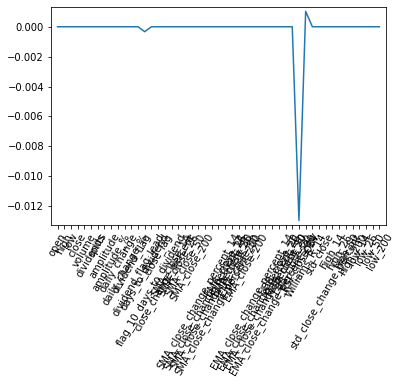

Int64Index([4, 13, 36, 37, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.33937033430704316
 Balanced Accuracy (CV):  0.3669384689649801
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, m

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: AAL


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.311463013261814
 Balanced Accuracy (CV):  0.3454297236829373
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.32762090230444657

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


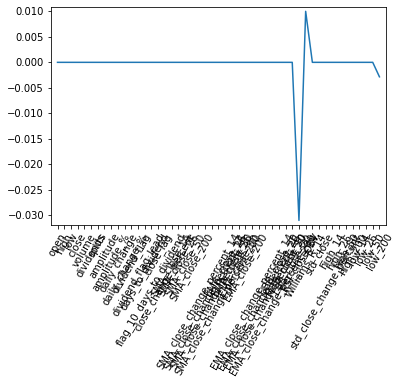

Int64Index([4, 36, 37, 38, 48], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: RSI_close_14',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: low_200'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3333333333333333
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: MSFT


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.36170212765957444
 Balanced Accuracy (CV):  0.3412071892602866
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.349684791174152

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3546099290780142
 Balanced Accuracy (CV):  0.3394880431545406
Best model is:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)  with Balanced Accuracy= 0.36170212765957444  and CV BA= 0.3394880431545406
Ticker: AAPL
Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


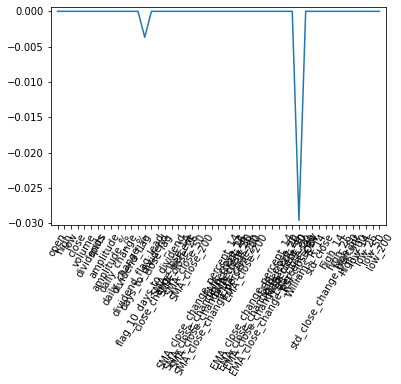

Int64Index([4, 13, 36, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: RSI_close_14', 'Columns selected: OBV'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3154179496883196
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: AAPL
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3366546909642538
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.333

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.33643698688015283
 Balanced Accuracy (CV):  0.34337751224684193
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        

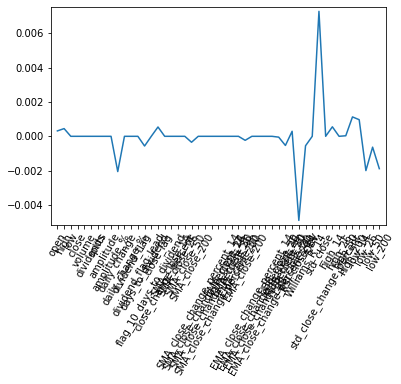

Int64Index([ 0,  1,  3,  4,  9, 13, 15, 18, 19, 20, 28, 33, 34, 35, 36, 37, 38,
            39, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: daily_change', 'Columns selected: days_to_dividend',
       'Columns selected: close_lag', 'Columns selected: SMA_close_26',
       'Columns selected: SMA_close_50', 'Columns selected: SMA_close_200',
       'Columns selected: EMA_close_200', 'Columns selected: UBB_close_20',
       'Columns selected: MBB_close_20', 'Columns selected: LBB_close_20',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: std_close',
       'Columns selected: high_14', 'Columns selected: high_26',
       'Columns selected: high_50', 'Columns selected: high_200',
       'Columns selected: low_14', 'Columns selected: low_26',
       'Colum

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3683657790807507
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3567354826546003

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3763983157365511
 Balanced Accuracy (CV):  0.3325025790553183
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3369630973986691
 Balanced Accuracy (CV):  0.3400568459474617
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


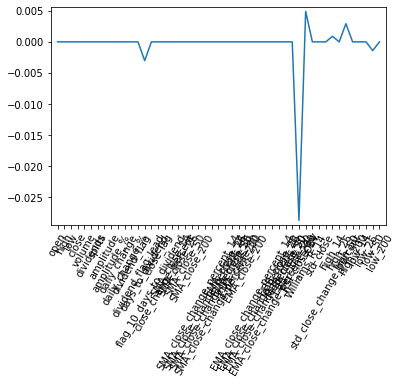

Int64Index([4, 13, 36, 37, 38, 41, 43, 47], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: high_14',
       'Columns selected: high_50', 'Columns selected: low_50'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3333333333333333
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
               

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3369630973986691
 Balanced Accuracy (CV):  0.3400568459474617
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3000604960677556
 Balanced Accuracy (CV):  0.3618596580989913


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3036902601330913
 Balanced Accuracy (CV):  0.34902715270053647
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alph

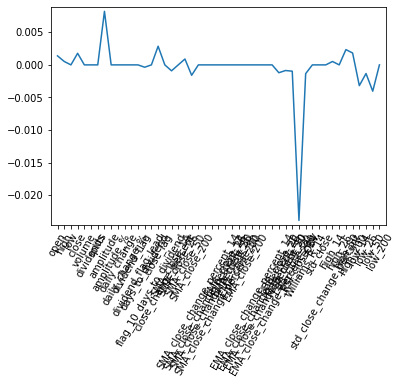

Int64Index([ 0,  1,  3,  4,  7, 13, 15, 17, 19, 20, 33, 34, 35, 36, 37, 38, 41,
            43, 44, 45, 46, 47],
           dtype='int64')
Index(['Columns selected: open', 'Columns selected: high',
       'Columns selected: close', 'Columns selected: volume',
       'Columns selected: amplitude', 'Columns selected: days_to_dividend',
       'Columns selected: close_lag', 'Columns selected: SMA_close_14',
       'Columns selected: SMA_close_50', 'Columns selected: SMA_close_200',
       'Columns selected: UBB_close_20', 'Columns selected: MBB_close_20',
       'Columns selected: LBB_close_20', 'Columns selected: RSI_close_14',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: high_14', 'Columns selected: high_50',
       'Columns selected: high_200', 'Columns selected: low_14',
       'Columns selected: low_26', 'Columns selected: low_50'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3703703703703703
 Balanced Accuracy (CV):  0.24395060592878534
Best model is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
     

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


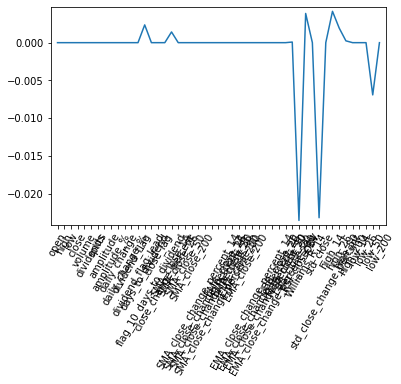

Int64Index([4, 13, 17, 35, 36, 37, 38, 39, 41, 42, 43, 47], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: SMA_close_14', 'Columns selected: LBB_close_20',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: std_close',
       'Columns selected: high_14', 'Columns selected: high_26',
       'Columns selected: high_50', 'Columns selected: low_50'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.338757949869061
 Balanced Accuracy (CV):  0.33635703484730745
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=Non

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3703703703703703
 Balanced Accuracy (CV):  0.24395060592878534
Best model is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
     

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: NVDA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3853348297792742
 Balanced Accuracy (CV):  0.338925281432403
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3434343434343434


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3673436877737953
 Balanced Accuracy (CV):  0.32956107028722703
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


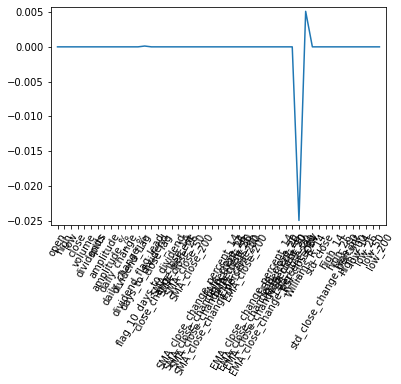

Int64Index([4, 13, 36, 37, 38], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3335923308127584
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, mi

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3673436877737953
 Balanced Accuracy (CV):  0.32956107028722703
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: CTSH


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3449621664675428
 Balanced Accuracy (CV):  0.3408791055035533
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3639984070091597

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.36328156113102356
 Balanced Accuracy (CV):  0.3376409696134711
Best model is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
     

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


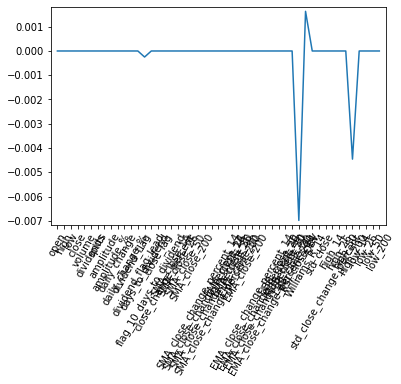

Int64Index([4, 13, 36, 37, 38, 44], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: days_to_dividend',
       'Columns selected: RSI_close_14', 'Columns selected: Williams_R_14',
       'Columns selected: OBV', 'Columns selected: high_200'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.31958274063537223
 Balanced Accuracy (CV):  0.366176211942987
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
           

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: TSLA


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.34815078236130864
 Balanced Accuracy (CV):  0.3458119018815917
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.367591275486012

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.3316528602906312
 Balanced Accuracy (CV):  0.32753143589299943
Best model is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
     

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3522429162849674
 Balanced Accuracy (CV):  0.2092324458686247
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha

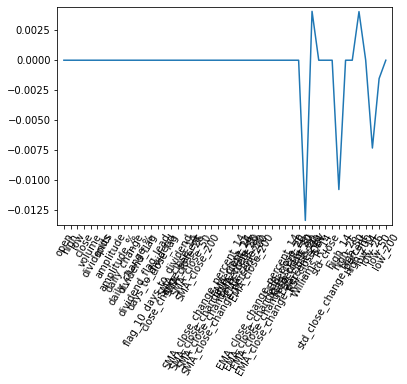

Int64Index([4, 36, 37, 38, 41, 44, 46, 47], dtype='int64')
Index(['Columns selected: volume', 'Columns selected: RSI_close_14',
       'Columns selected: Williams_R_14', 'Columns selected: OBV',
       'Columns selected: high_14', 'Columns selected: high_200',
       'Columns selected: low_26', 'Columns selected: low_50'],
      dtype='object')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3284790292359987


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3522429162849674
 Balanced Accuracy (CV):  0.2092324458686247
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Ticker: M


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Balanced Accuracy: 0.3333333333333333
 Balanced Accuracy (CV):  0.3309769159921975
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
Balanced Accuracy: 0.3333333333333333

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Balanced Accuracy: 0.413620166891997
 Balanced Accuracy (CV):  0.2654767518065367
Best model is:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           

In [ ]:
column_names = ["ticker", "preprocessing","label","best_model", "best_balanced_accuracy", "cv_score_in_best"]
clas_models_df = pd.DataFrame(columns = column_names)
i = 0
for s in stocks:
    # Modelos para clasificacion de tendencias
    ticker, label, best_classifier, best_balanced_accuracy, cv_scores_mean = best_model_clas (classifiers=classifiers,label='close_change_percent_lead_flag',train_size=0.9,test_size=0.1,ticker=s,df=df)   
    clas_list = [ticker,'All features',label,best_classifier,best_balanced_accuracy, cv_scores_mean]
    aux_models_df = pd.DataFrame([clas_list],columns=column_names)
    clas_models_df = clas_models_df.append(aux_models_df,ignore_index=True)
    i = i + 1
    # Modelos para clasificacion de tendencias usando solo los features obtenidos con LASSO
    ticker, label, best_classifier, best_balanced_accuracy, cv_scores_mean = best_model_clas_features(classifiers=classifiers,label='close_change_percent_lead_flag',train_size=0.9,test_size=0.1,ticker=s,df=df)   
    clas_list = [ticker,'LASSO features',label,best_classifier,best_balanced_accuracy, cv_scores_mean]
    aux_models_df = pd.DataFrame([clas_list],columns=column_names)
    clas_models_df = clas_models_df.append(aux_models_df,ignore_index=True)
    i = i + 1
    # Modelos para clasificacion de tendencias usando PCA
    ticker, label, best_classifier, best_balanced_accuracy, cv_scores_mean = best_pca_model_clas(classifiers=classifiers,label='close_change_percent_lead_flag',train_size=0.9,test_size=0.1,ticker=s,df=df)   
    clas_list = [ticker,'PCA features',label,best_classifier,best_balanced_accuracy, cv_scores_mean]
    aux_models_df = pd.DataFrame([clas_list],columns=column_names)
    clas_models_df = clas_models_df.append(aux_models_df,ignore_index=True)
    i = i + 1

print(clas_models_df)
clas_models_df.to_csv(path_or_buf='best_classification_models.csv')

In [ ]:
! zip models.zip *.sav

  adding: AAL_close_change_percent_lead_allfeatures.sav (deflated 53%)
  adding: AAL_close_change_percent_lead_flag_allfeatures.sav (deflated 65%)
  adding: AAL_close_change_percent_lead_flag_lassofeatures.sav (deflated 66%)
  adding: AAL_close_change_percent_lead_flag_subsetfeatures.sav (deflated 67%)
  adding: AAL_close_change_percent_lead_lassofeatures.sav (deflated 57%)
  adding: AAL_close_change_percent_lead_subsetfeatures.sav (deflated 58%)
  adding: AAL_close_lead_allfeatures.sav (deflated 65%)
  adding: AAL_close_lead_lassofeatures.sav (deflated 19%)
  adding: AAL_close_lead_subsetfeatures.sav (deflated 70%)
  adding: AAPL_close_change_percent_lead_allfeatures.sav (deflated 6%)
  adding: AAPL_close_change_percent_lead_flag_allfeatures.sav (deflated 10%)
  adding: AAPL_close_change_percent_lead_flag_lassofeatures.sav (deflated 24%)
  adding: AAPL_close_change_percent_lead_flag_subsetfeatures.sav (deflated 67%)
  adding: AAPL_close_change_percent_lead_lassofeatures.sav (deflated 

In [ ]:
clas_models_df = pd.read_csv('best_classification_models.csv',index_col=0)

In [ ]:
def backtesting_clasificacion_cambio(mod, backtesting_df,ganancias_backtesting_df,ticker,comision,margen_cobertura,monto_inversion,fecha_inicio,fecha_fin,num_train):
    i=0
    y_pred, classifier = preparacion_backtesting(ticker,fecha_inicio,fecha_fin,mod,num_train, label='close_change_percent_lead_flag')
    # Defino parámetros básicos
    status = 'cash'
    cash = monto_inversion
    invertido = 0
    tenencia_acciones = 0
    valor_cartera = cash + invertido
    comisiones_pagadas = 0
    comision = 0.005
    # Simulación de la estrategia
    fechas = df.loc[(df.index.get_level_values('date') >=fecha_inicio) & (df.index.get_level_values('date') <= fecha_fin) & (df.index.get_level_values('ticker')==ticker)].index.get_level_values('date').tolist()
    for f in fechas:
        cantidad_compra = 0
        cantidad_venta = 0
        # Genero conjuntos de train y de predicción
        index = fechas.index(f)     
        prediccion = y_pred[index]
        precio_cierre = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['close_lead'].values[0] 
        precio_cierre_hoy = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['close'].values[0] 
        precio_apertura_siguiente = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['open_lead'].values[0] 
        cambio_cierre = df.loc[(df.index.get_level_values('date') == f) & (df.index.get_level_values('ticker')==ticker)]['close_change_percent_lead_flag'].values[0] 
        print(f,'. Predicción= ',prediccion,' Cambio Real= ',cambio_cierre,' Precio Cierre= ',precio_cierre)
        # Tomo decisión de inversión
        if f<fechas[-1]:
          if (precio_apertura_siguiente < precio_cierre_hoy*(1+margen_cobertura) and prediccion=='Up' and status == 'cash'):
            cantidad_compra = int(cash/(precio_apertura_siguiente*(1+comision)))
            tenencia_acciones += cantidad_compra
            invertido += cantidad_compra*precio_apertura_siguiente
            cash -=cantidad_compra*precio_apertura_siguiente*(1+comision)
            comisiones_pagadas += cantidad_compra*precio_apertura_siguiente*comision
            status = 'invertido'
            print('Se compraron ',cantidad_compra,' acciones a un precio de ',precio_apertura_siguiente)
          elif (precio_apertura_siguiente > precio_cierre_hoy*(1-margen_cobertura) and prediccion=='Down' and status == 'invertido'):   
            cantidad_venta = tenencia_acciones
            tenencia_acciones -= cantidad_venta
            invertido -= cantidad_venta*precio_apertura_siguiente
            cash += cantidad_venta*precio_apertura_siguiente*(1-comision)
            comisiones_pagadas += cantidad_venta*precio_apertura_siguiente*comision
            status = 'cash'
            print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_apertura_siguiente)
        # Actualizo valor de la cartera en el día (a la apertura del día siguiente en el momento de compra/venta)
        if f<fechas[-1]:
          invertido = tenencia_acciones*precio_apertura_siguiente
        else:
          #Vendo todo lo que quedó invertido
          cantidad_venta = tenencia_acciones
          tenencia_acciones -= cantidad_venta
          invertido -= cantidad_venta*precio_cierre
          cash += cantidad_venta*precio_cierre*(1-comision)
          comisiones_pagadas += cantidad_venta*precio_cierre*comision
          status = 'cash'
          print('Se vendieron ',cantidad_venta,' acciones a un precio de ',precio_cierre)
          invertido = tenencia_acciones*precio_cierre
        valor_cartera = cash + invertido
        print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
        # Hacer tracking dia a dia de las operaciones y de los saldos de cash e invertido 
        estrategia = 'Predicción de la dirección del cambio del precio al cierre'
        backtesting_df = backtesting_df.append({'ticker': ticker, 'estrategia': estrategia, 'best_model': classifier,'date': f, 'prediccion': prediccion, 'precio_cierre': precio_cierre_hoy, 'valor_cartera': valor_cartera, 'cantidad_compra': cantidad_compra, 'cantidad_venta': cantidad_venta, 'tenencia_acciones': tenencia_acciones, 'invertido': invertido,'cash': cash,'comisiones_pagadas': comisiones_pagadas,'status': status},ignore_index=True)
    ganancia = valor_cartera-monto_inversion
    ganancia_porcentual = ganancia/monto_inversion*100
    retornos_diarios = backtesting_df.loc[(backtesting_df['ticker']==ticker) & (backtesting_df['estrategia']=='Compro primer dia y vendo el ultimo')]['valor_cartera'].pct_change(1)
    retornos_diarios = retornos_diarios.loc[pd.notnull(retornos_diarios)]
    volatilidad = 100 * retornos_diarios.values.std()
    sharpe_ratio = (ganancia_porcentual-0)/volatilidad
    print('El valor de la cartera es: ',valor_cartera,'. Cash: ',cash,' , Invertido: ',invertido)
    print('El valor final de la cartera es ',valor_cartera,', con una ganancia del ',ganancia_porcentual, '% para el ticker ',ticker, ' logrando un SHARPE Ratio de ', sharpe_ratio)
    ganancias_backtesting_df = ganancias_backtesting_df.append({'ticker' : ticker , 'estrategia' : 'Predicción de la dirección del cambio del precio al cierre', 'ganancia': ganancia,'ganancia_porcentual': ganancia_porcentual,'volatilidad': volatilidad, 'sharpe_ratio': sharpe_ratio} , ignore_index=True)
    return backtesting_df, ganancias_backtesting_df
            

In [ ]:
for ticker in stocks:
  models = clas_models_df.loc[(clas_models_df['ticker'] == ticker) & (clas_models_df['label'] == 'close_change_percent_lead_flag')]
  for mod in models.iterrows():
    backtesting_df, ganancias_backtesting_df = backtesting_clasificacion_cambio(mod=mod, backtesting_df=backtesting_df,ganancias_backtesting_df=ganancias_backtesting_df,ticker=ticker,comision=0.005,margen_cobertura=0.01,monto_inversion=10000,fecha_inicio='2019-01-01',fecha_fin='2019-12-27',num_train=1760)
print(ganancias_backtesting_df)

Ticker:  AAL
Test columns:  Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits',
       'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%',
       'dividend_flag', 'dividend_flag_lead', 'days_to_dividend',
       'flag_10_days_to_dividend', 'close_lag', 'close_change_percent',
       'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200',
       'SMA_close_change_percent_14', 'SMA_close_change_percent_26',
       'SMA_close_change_percent_50', 'SMA_close_change_percent_200',
       'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200',
       'EMA_close_change_percent_14', 'EMA_close_change_percent_26',
       'EMA_close_change_percent_50', 'EMA_close_change_percent_200',
       'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14',
       'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent',
       'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26',
       'low_50', 'low_200'],
      dtype='object')
AAL_c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test columns:  ['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits', 'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%', 'dividend_flag', 'dividend_flag_lead', 'days_to_dividend', 'flag_10_days_to_dividend', 'close_lag', 'close_change_percent', 'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200', 'SMA_close_change_percent_14', 'SMA_close_change_percent_26', 'SMA_close_change_percent_50', 'SMA_close_change_percent_200', 'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200', 'EMA_close_change_percent_14', 'EMA_close_change_percent_26', 'EMA_close_change_percent_50', 'EMA_close_change_percent_200', 'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14', 'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent', 'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26', 'low_50', 'low_200']
AAL_close_change_percent_lead_flag_lassofeatures.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              co

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test columns:  ['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits', 'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%', 'dividend_flag', 'dividend_flag_lead', 'days_to_dividend', 'flag_10_days_to_dividend', 'close_lag', 'close_change_percent', 'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200', 'SMA_close_change_percent_14', 'SMA_close_change_percent_26', 'SMA_close_change_percent_50', 'SMA_close_change_percent_200', 'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200', 'EMA_close_change_percent_14', 'EMA_close_change_percent_26', 'EMA_close_change_percent_50', 'EMA_close_change_percent_200', 'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14', 'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent', 'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26', 'low_50', 'low_200']
MSFT_close_change_percent_lead_flag_lassofeatures.sav
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
           

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Streaming output truncated to the last 5000 lines.
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-04 00:00:00 . Predicción=  0.0  Cambio Real=  Up  Precio Cierre=  1211.3800048828125
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-05 00:00:00 . Predicción=  0.0  Cambio Real=  None  Precio Cierre=  1204.9300537109375
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-06 00:00:00 . Predicción=  0.0  Cambio Real=  None  Precio Cierre=  1204.4100341796875
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-09 00:00:00 . Predicción=  0.0  Cambio Real=  None  Precio Cierre=  1206.0
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-10 00:00:00 . Predicción=  0.0  Cambio Real=  Up  Precio Cierre=  1220.1700439453125
El valor de la cartera es:  10000.0 . Cash:  10000  , Invertido:  0.0
2019-09-11 00:00:00 . Predicción=  0.0  Cambio Real=  Up  Precio Cierr

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test columns:  ['open', 'high', 'low', 'close', 'volume', 'dividends', 'splits', 'amplitude', 'amplitude_%', 'daily_change', 'daily_change_%', 'dividend_flag', 'dividend_flag_lead', 'days_to_dividend', 'flag_10_days_to_dividend', 'close_lag', 'close_change_percent', 'SMA_close_14', 'SMA_close_26', 'SMA_close_50', 'SMA_close_200', 'SMA_close_change_percent_14', 'SMA_close_change_percent_26', 'SMA_close_change_percent_50', 'SMA_close_change_percent_200', 'EMA_close_14', 'EMA_close_26', 'EMA_close_50', 'EMA_close_200', 'EMA_close_change_percent_14', 'EMA_close_change_percent_26', 'EMA_close_change_percent_50', 'EMA_close_change_percent_200', 'UBB_close_20', 'MBB_close_20', 'LBB_close_20', 'RSI_close_14', 'Williams_R_14', 'OBV', 'std_close', 'std_close_change_percent', 'high_14', 'high_26', 'high_50', 'high_200', 'low_14', 'low_26', 'low_50', 'low_200']
TSLA_close_change_percent_lead_flag_lassofeatures.sav
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
           

In [ ]:
backtesting_df.to_csv(path_or_buf='backtesting_results_classifier.csv')
print(backtesting_df)
ganancias_backtesting_df.to_csv(path_or_buf='backtesting_results_resumen.csv')
print(ganancias_backtesting_df)

      ticker  ...     status
0        AAL  ...  invertido
1        AAL  ...  invertido
2        AAL  ...  invertido
3        AAL  ...  invertido
4        AAL  ...  invertido
...      ...  ...        ...
24995      M  ...       cash
24996      M  ...       cash
24997      M  ...       cash
24998      M  ...       cash
24999      M  ...       cash

[25000 rows x 14 columns]
   ticker  ... sharpe_ratio
0     AAL  ...    -5.450711
1    MSFT  ...    46.235875
2    AAPL  ...    51.071188
3    AMZN  ...    13.981292
4      BA  ...     1.780266
..    ...  ...          ...
95   TSLA  ...     0.000000
96   TSLA  ...    16.499893
97      M  ...   -10.250318
98      M  ...     0.000000
99      M  ...     0.000000

[100 rows x 6 columns]


In [ ]:
ganancias_backtesting_df.groupby('estrategia').mean()

ganancia  ...  sharpe_ratio
estrategia                                                       ...              
Compro primer dia y vendo el ultimo                 2442.908554  ...     14.934323
Prediccion del % de cambio del precio al cierre     1327.911194  ...      7.321438
Prediccion del precio al cierre                      636.686917  ...      2.879051
Predicción de la dirección del cambio del preci...   577.677189  ...      2.830273

[4 rows x 4 columns]

## Conclusiones finales

El estudio realizado muestra evidencias concluyentes a favor de las técnicas de trading algorítmico. La utilización de modelos de Machine Learning para definir estrategias de compra y venta de acciones individuales permite obtener mejores resultados en términos de riesgo-retorno que la estrategia base, a la vez que funciona como escudo ante la pérdida de capital en activos que presentan tendencias a la baja. Finalmente, este trabajo cumplió con el objetivo de comparar con un criterio común la performance de estrategias de trading basadas en técnicas de regresión y clasificación refutando la hipótesis inicial que sostenía que los modelos de clasificación darían mejores resultados que los de regresión.